Ссылка на задачу
https://russianhackers.notion.site/1-Data-Science-4cc89ba42de1429bbac316f59bf07a3b#5e44c7fca6ed46de93ae540096c7c68f

# Задача 1 – Продуйте металл через Data Science

## Контекст

При производстве стали чугун "продувается" кислородом для удаления примесей. Этот процесс идёт в среднем 15-25 минут при температуре около 1600 градусов. За процессом следит машинист дистрибутора, который на основе своего опыта и специальных знаний определяет момент, когда процесс продувки нужно остановить. В процессе продувки металл насыщается кислородом, а его температура увеличивается. Если "передуть" чугун – сгорит больше металла и на выходе будет меньше стали, что приведет к потере прибыли, если "недодуть", то марка стали не будет удовлетворять заданным критериям и нужно будет "додувать", что замедляет производительность цеха.

Вам предстоит разработать алгоритм прогнозирования параметров чугуна – что может стать отличным помощником для машиниста и существенно улучшить производство ЕВРАЗа

## Описание задачи

### Формулировка

### Задача - разработать алгоритм предсказания содержание углерода и температуру чугуна.

В этой задаче две подзадачи

1. Реализовать алгоритм, предсказывающий содержание углерода и температуры чугуна на момент конца плавки металла
2. Оптимизационная задача – придумать как обобщить алгоритм из пункта 1 на ситуацию реального производства. В реальном времени мы не знаем, когда наступит конец продувки, а должны определить это сами на основании прогнозируемых параметров чугуна

### Данные

**Исходные данные**

В рамках этой задачи вам будут даны данные о продувки чугуна в цехе:

- **produv** – Таблица содержит основные параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы
- **lom** – Вместе с чугуном в фурму засыпают лом - это часть технологического процесса. Таблица содержит вес и тип ломов, использованных в каждой плавке
- **plavki** – Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования
- **sip** – Сыпучие добавки, используемые в технологическом процессе
- **chronom** – хронометраж - время начала и конца различных операций во время плавки
- **chugun** – Химический состав и характеристики чугуна
- **gas** – Информация об анализе отходящих газов
- **target** – целевые значения

# Решение

Импортируем библиотеки и их модули

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from IPython.display import Image
import datetime
from sklearn.preprocessing import LabelEncoder
pd.set_option('max_colwidth', 500)
import seaborn as sns
import  matplotlib.pyplot  as  plt 
pd.options.display.max_columns = None
import re

## Описание процесса

Кислородно-конвертерный процесс это процесс выплавки стали из жидкого чугуна в конвертере с основной футеровкой и продувкой кислородом через водоохлаждаемую фурму. Кислородный конвертор представляет собой сосуд грушевидной формы из стального листа, футерованный основным кирпичом. В процессе работы конвертер может поворачиваться на цапфах вокруг горизонтальной оси на 360 градусов для завалки металлолома, заливки чугуна, слива стали и шлака. 

Шихтовыми материалами кислородно-конвертерного процесса являются:

жидкий передельный чугун;
металлолом;
шлакообразующие (известь, полевой шпат, железная руда, бокситы).
Перед плавкой конвертер наклоняют, загружают через горловину металлолом (скрап) и заливают чугун при температуре 1250 – 1400 °C. После этого конвертер поворачивают в вертикальное положение, вводят водоохлаждаемую фурму и через нее подают кислород. Одновременно с началом продувки в конвертер загружают известь, бокситы, железную руду для образования жидкоподвижного шлака. Кислород проникает в металл, вызывает его циркуляцию и перемешивание со шлаком.

В зоне контакта кислородной струи с чугуном интенсивно окисляется железо, так как концентрация его выше, чем примесей. Образующийся оксид железа растворяется в шлаке и металле, обогащая металл кислородом. Растворенный в металле кислород, окисляет кремний, марганец, углерод и содержание их в металле понижается. При этом происходит разогрев ванны металла теплотой, выделяющийся при окислении примесей. Благодаря присутствию шлаков с большим содержанием CaO и FeO происходит удаление из металла фосфора в начале продувки ванны кислородом, когда температура ее еще не высока. В чугунах, перерабатываемых в кислородных конвертерах, не должно быть более 0,15%P. При повышенном содержании фосфора для его удаления необходимо сливать шлак и наводить новый. Удаление серы из металла в шлак проходит в течении всей плавки. Однако для передела в сталь в кислородных конвертерах применяют чугун с содержанием до 0,07%S. 

Подачу кислорода заканчивают, когда содержание углерода в металле соответствует заданному. После этого конвертер наклоняют, выпуская сталь в ковш через летку и одновременно вводят в ковш раскислители и легирующие добавки. В ковш сливают также небольшое количество шлака, который предохраняет металл в ковше от быстрого охлаждения. Оставшейся шлак сливают через горловину в шлаковую чашу.

Информация взята с сайта METALSPACE (https://metalspace.ru/education-career/osnovy-metallurgii/proizvodstvo-stali/407-konverternyj-sposob-proizvodstva-stali.html)

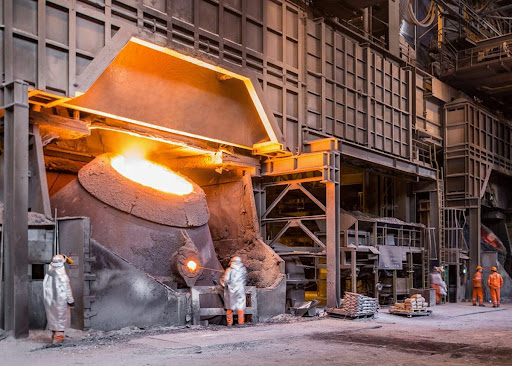

In [2]:
Image("images/image_1.jpg", width=600)

Продолжительность цикла плавки складывается из операций длительность которых приведена ниже (мин): \
1) Завалка лома - 3-4;\
2) Заливка чугуна - 3-4;\
3) Продувка жидкой ванны кислородом - 10-25;\
4) Взятие пробы, ожидание анализа - 3-4;\
5) Выпуск металла - 5-10;\
6) Слив шлака - 2-3;\
7) Подготовка конвертера - 3; \
8) Неучтенные задержки - 3.

---
Общая продолжительность цикла - 25-50 минут.

## EDA + Feature engineering

In [3]:
data_produv = pd.read_csv('datasets/produv_train.csv')
data_lom = pd.read_csv('datasets/lom_train.csv')
data_plavki = pd.read_csv('datasets/plavki_train.csv')
data_sip = pd.read_csv('datasets/sip_train.csv')
data_chronom = pd.read_csv('datasets/chronom_train.csv')
data_chugun = pd.read_csv('datasets/chugun_train.csv')
data_gas = pd.read_csv('datasets/gas_train.csv')
data_target = pd.read_csv('datasets/target_train.csv')

### Датасет produv (Параметры продувки)

NPLV - номер плавки

SEC - время измерения

RAS - расход кислорода на продувку

POL - положение фурмы для продувки

In [4]:
data_produv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729802 entries, 0 to 4729801
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   NPLV    int64  
 1   SEC     object 
 2   RAS     float64
 3   POL     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 144.3+ MB


In [5]:
data_produv

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.000000,3.920000
1,510008,2021-01-01 03:18:28,382.000000,3.920000
2,510008,2021-01-01 03:18:30,553.000000,3.920000
3,510008,2021-01-01 03:18:32,701.000000,3.920000
4,510008,2021-01-01 03:18:34,813.000000,3.920000
...,...,...,...,...
4729797,512322,2021-05-05 16:30:46,363.996249,4.850045
4729798,512322,2021-05-05 16:30:48,363.996999,4.850036
4729799,512322,2021-05-05 16:30:50,363.997749,4.850027
4729800,512322,2021-05-05 16:30:52,363.998499,4.850018


Посмотрим сколько раз за плавку происходит измерение высоты фурмы и подачи кислорода.

In [6]:
measurement_count = Counter(data_produv['NPLV'])
measurement_count.most_common()[0], measurement_count.most_common()[-1]

((512322, 385864), (510189, 912))

In [7]:
data_produv[['RAS', 'POL']].median()

RAS    277.638212
POL      4.709795
dtype: float64

Построим графики распределения объема продувки и положения фурмы.

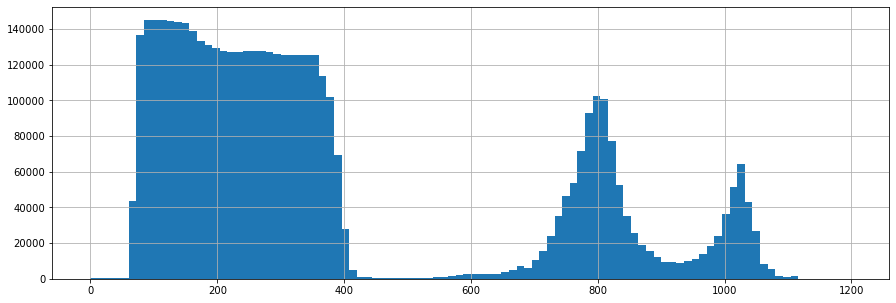

In [8]:
data_produv['RAS'].hist(bins = 100, range = (0, 1200), figsize = (15, 5));

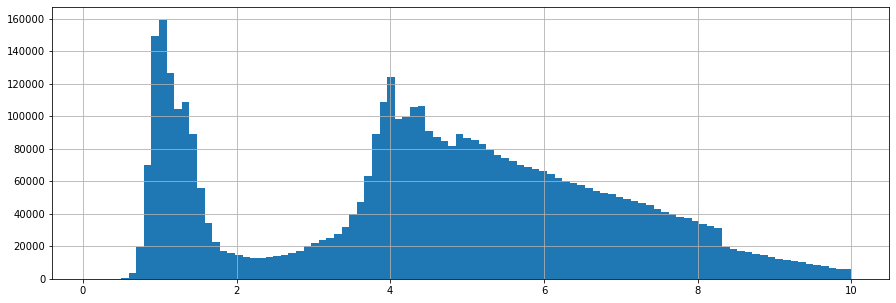

In [9]:
data_produv['POL'].hist(bins = 100, range = (0.1, 10), figsize = (15, 5));

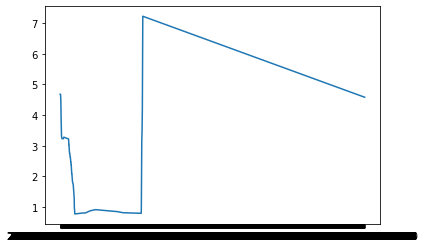

In [10]:
data_one_plav = data_produv.query('NPLV == 510020')
x = data_one_plav['SEC']
y = data_one_plav['POL']
plt.plot(x, y);

In [11]:
data_produv
data_furm =  data_produv.query("POL < 2")
data_one_plav2 = data_furm.query('NPLV == 510020')

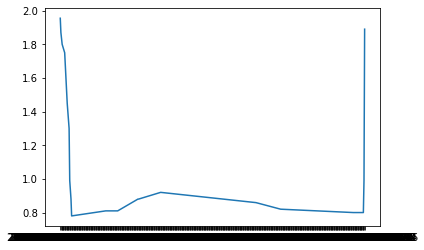

In [12]:
x = data_one_plav2['SEC']
y = data_one_plav2['POL']
plt.plot(x, y);

In [13]:
data_furm.query("NPLV == 510008")

,NPLV,SEC,RAS,POL
62,510008,2021-01-01 03:20:30,907.422222,1.999778
63,510008,2021-01-01 03:20:32,907.333333,1.996667
64,510008,2021-01-01 03:20:34,907.244444,1.993556
65,510008,2021-01-01 03:20:36,907.155556,1.990444
66,510008,2021-01-01 03:20:38,907.066667,1.987333
...,...,...,...,...
569,510008,2021-01-01 03:37:24,771.000000,0.820000
570,510008,2021-01-01 03:37:26,768.000000,0.820000
571,510008,2021-01-01 03:37:28,765.000000,0.820000
572,510008,2021-01-01 03:37:30,683.000000,0.820000


In [14]:
model_produv_furm = data_furm.groupby('NPLV').agg(lambda x: x.median()).reset_index()

In [15]:
model_produv_furm.drop(['RAS'], axis = 1, inplace = True)

In [16]:
data_chronom[['NPLV', 'VR_NACH','VR_KON','NOP']]

,NPLV,VR_NACH,VR_KON,NOP
0,510008,2011-01-01 10:28:13,2011-01-01 10:32:15,межпл. простой
1,510008,2021-01-01 03:01:07,2021-01-01 03:08:11,межпл. простой
2,510008,2021-01-01 03:01:19,2021-01-01 03:03:43,Осмотр конвертера
3,510008,2021-01-01 03:03:43,2021-01-01 03:05:23,Наведение гарнисажа
4,510008,2021-01-01 03:05:23,2021-01-01 03:06:09,Слив шлака
...,...,...,...,...
34401,512322,2021-04-26 18:31:26,2021-04-26 18:41:10,Повалка
34402,512322,2021-04-26 18:41:10,2021-04-26 18:47:40,Выпуск металла
34403,512322,2021-04-26 18:46:15,2021-04-26 18:46:15,Отсечка шлака
34404,512322,2021-04-26 18:47:40,2021-04-26 18:48:40,Прерыв. выпуска


In [17]:
model_produv_V02 = data_produv.merge((data_chronom[['NPLV', 'VR_NACH','VR_KON','NOP']].query('NOP == "Продувка"')), how = 'left', on = 'NPLV')
model_produv_V02 = model_produv_V02.query('SEC > VR_NACH and SEC < VR_KON')
model_produv_V02.drop(['SEC', 'VR_NACH', 'VR_KON', 'NOP', 'POL'], axis = 1, inplace = True)
model_produv_V02 = model_produv_V02.groupby('NPLV').agg(lambda x: 2*x.sum()).reset_index()
model_produv_V02

,NPLV,RAS
0,510008,9.746384e+05
1,510009,1.021916e+06
2,510010,1.005546e+06
3,510011,8.522880e+05
4,510012,1.007318e+06
...,...,...
2058,512318,9.065120e+05
2059,512319,9.437340e+05
2060,512320,8.833000e+05
2061,512321,9.448760e+05


In [18]:
model_produv = model_produv_furm.merge(model_produv_V02, how = 'left', on = 'NPLV')
model_produv

,NPLV,POL,RAS
0,510008,0.851547,9.746384e+05
1,510009,0.807292,1.021916e+06
2,510010,0.783986,1.005546e+06
3,510011,0.966364,8.522880e+05
4,510012,0.800000,1.007318e+06
...,...,...,...
2058,512318,0.900000,9.065120e+05
2059,512319,0.920000,9.437340e+05
2060,512320,0.960000,8.833000e+05
2061,512321,1.100000,9.448760e+05


### Датасет lom (Параметры лома)

In [19]:
data_lom.head(10)

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800
5,510009,13,КП,6000
6,510010,4,К,45900
7,510010,13,КП,2000
8,510010,23,ЛЧ,6000
9,510010,8,О,22400


In [20]:
data_lom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6376 entries, 0 to 6375
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NPLV    6376 non-null   int64 
 1   VDL     6376 non-null   int64 
 2   NML     6376 non-null   object
 3   VES     6376 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 199.4+ KB


In [21]:
data_lom.describe()

,NPLV,VDL,VES
count,6376.000000,6376.000000,6376.000000
mean,511197.640213,14.079831,22411.946048
std,667.903450,14.485034,21490.405110
min,510008.000000,3.000000,800.000000
25%,510624.000000,4.000000,6000.000000
50%,511217.000000,8.000000,12100.000000
75%,511775.000000,13.000000,39000.000000
max,512322.000000,63.000000,124200.000000


NPLV - номер плавки

VDL - код лома

NML - наименование лома

VES - вес лома

Учтем содержание элементов для каждой марки лома:

Посмотрим на интервалы по лому для каждой марки.

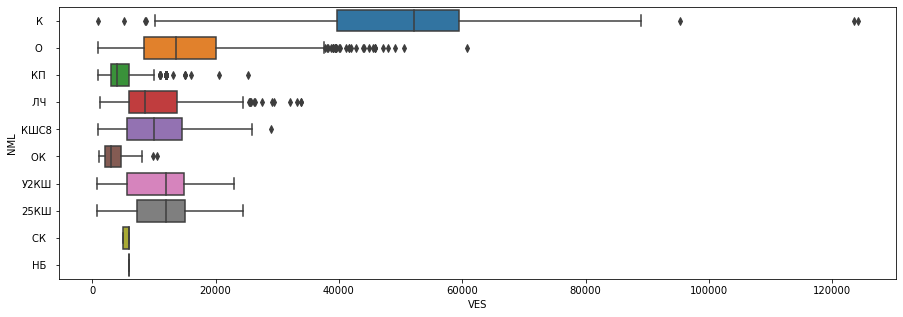

In [22]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="VES", y= "NML", data = data_lom, orient = "h") 

Из данной таблицы для каждой плавки возьмем код лома и вес лома. \
Вид лома влияет на скорость расплавления и другие физико-химические процессы происходящие в агрегате.
Вес лома непосредственно влияет на количество энергии которое необходимо затратить на его расплавление, то есть на расход кислорода и время продувки, а также на объем углерода и других легирующих элементов которые будут внесены вместе с ломом в расплав.

In [23]:
data_lom_ohe = data_lom
col_ohe = pd.get_dummies(data_lom['VDL'], prefix = 'VDL')
data_lom_ohe = pd.concat((data_lom_ohe, col_ohe), axis=1).drop(['VDL'], axis=1)


vdl_list = data_lom_ohe.columns.tolist()[3:]
for col in vdl_list:
    data_lom_ohe[col] = data_lom_ohe[col]*data_lom_ohe['VES']
data_lom_ohe.drop(['NML', 'VES'], axis=1, inplace = True)

Создадим таблицу в которой каждый вид лома будет отдельным признаком и укажем его вес в плавке.

In [24]:
data_lom_ohe.head(10)

,NPLV,VDL_3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63
0,510008,0,56500,0,0,0,0,0,0,0,0
1,510008,0,0,16700,0,0,0,0,0,0,0
2,510008,0,0,0,3000,0,0,0,0,0,0
3,510009,0,49800,0,0,0,0,0,0,0,0
4,510009,0,0,22800,0,0,0,0,0,0,0
5,510009,0,0,0,6000,0,0,0,0,0,0
6,510010,0,45900,0,0,0,0,0,0,0,0
7,510010,0,0,0,2000,0,0,0,0,0,0
8,510010,0,0,0,0,0,6000,0,0,0,0
9,510010,0,0,22400,0,0,0,0,0,0,0


In [25]:
data_lom_ohe = data_lom_ohe.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
data_lom_ohe

,NPLV,VDL_3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63
0,510008,0,56500,16700,3000,0,0,0,0,0,0
1,510009,0,49800,22800,6000,0,0,0,0,0,0
2,510010,0,45900,22400,2000,0,6000,0,0,0,0
3,510011,0,51900,29200,3000,0,0,0,0,0,0
4,510012,0,64000,6100,6000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,0,51700,3300,3000,0,11500,4100,0,0,0
2059,512319,0,46400,15300,5000,0,9900,0,0,0,0
2060,512320,0,41400,0,5000,0,0,17800,0,0,0
2061,512321,0,59000,4200,3000,0,0,0,0,0,0


### Датасет plavki (Основная информация по плавке)

In [26]:
data_plavki.head(10)

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
5,510013,2021-01-01 08:22:12,2021-01-01 09:10:39,SC2M/ЭТ,МНЛС,976,цилиндрическая,16,5 сопловая,16
6,510014,2021-01-01 09:27:38,2021-01-01 10:25:35,SC2M/ЭТ,МНЛС,977,цилиндрическая,17,5 сопловая,17
7,510015,2021-01-01 10:51:27,2021-01-01 11:49:23,SC2M/ЭТ,МНЛС,978,цилиндрическая,18,5 сопловая,18
8,510016,2021-01-01 11:54:29,2021-01-01 12:42:03,SC2M/ЭТ,МНЛС,979,цилиндрическая,19,5 сопловая,19
9,510017,2021-01-01 12:58:00,2021-01-01 14:10:05,Ш2.1,МНЛЗ,980,цилиндрическая,20,5 сопловая,20


In [27]:
data_plavki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NPLV             2137 non-null   int64 
 1   plavka_VR_NACH   2137 non-null   object
 2   plavka_VR_KON    2137 non-null   object
 3   plavka_NMZ       2137 non-null   object
 4   plavka_NAPR_ZAD  2137 non-null   object
 5   plavka_STFUT     2137 non-null   int64 
 6   plavka_TIPE_FUR  2137 non-null   object
 7   plavka_ST_FURM   2137 non-null   int64 
 8   plavka_TIPE_GOL  2137 non-null   object
 9   plavka_ST_GOL    2137 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 167.1+ KB


NPLV - номер плавки

plavka_VR_NACH - время начала плавки.

plavka_VR_KON - время окончания плавки.

plavka_NMZ - марка заданная. \
Является важным параметром, т.к. в классическом конвертерном процессе содержание углерода в расплаве после продувки должно находиться на уровне не выше чем содержание углерода в выплавляемой марке стали. Остальные элементы, необходимые для получения заданной стали, будут добавлены позже в ковше и находятся за рамками нашей задачи.
Предположительно содержание углерода в выплавляемой стали должно быть близко к значению углерода которое необходимо найти.

plavka_NAPR_ZAD - направление разливки. \
Является важным параметром - показывает насколько мы должны перегреть металл для того или иного способа разливки стали.

plavka_STFUT - стойкость футеровки конвертера. \
Данная характеристика не должна влиять на целевые показатели. Исключим её из итоговой таблицы.

plavka_TIPE_FUR - тип фурмы. \
Предположительно данный признак незначительно влияет на результат, либо его влияние очень сильно коррелирует с признаком "Тип головки фурмы". Удалим признак из итоговой таблицы.

plavka_ST_FURM - стойкость фурмы. \
Данная характеристика не должна влиять на целевые показатели. Исключим её из итоговой таблицы.

plavka_TIPE_GOL - тип головки фурмы. \
Данный признак незначительно, но может влиять на физико-химические процессы в расплаве и скорость взаимодействия между кислородом и элементами в металле и шлаке. Но скорость реакций мы можем найти более корректно по отходящим газам. Исключим данный признак.

plavka_ST_GOL - стойкость головки фурмы. \
Данная характеристика не должна влиять на целевые показатели. Исключим её из итоговой таблицы.

Подготовим данные из датасета "plavki" необходимые для построения модели.

In [28]:
model_plav = data_plavki.drop(['plavka_VR_NACH', 'plavka_VR_KON', 'plavka_TIPE_FUR', 'plavka_STFUT', 'plavka_ST_FURM', 
                                'plavka_ST_GOL'], axis=1)

In [29]:
model_plav.head()

,NPLV,plavka_NMZ,plavka_NAPR_ZAD,plavka_TIPE_GOL
0,510008,С255,МНЛЗ,5 сопловая
1,510009,С255,МНЛЗ,5 сопловая
2,510010,Ст3пс/Э,Изл,5 сопловая
3,510011,Св-08А.z02,Изл,5 сопловая
4,510012,SC2M/ЭТ,МНЛС,5 сопловая


In [30]:
model_plav['plavka_TIPE_GOL'].unique().tolist()

['5 сопловая          ',
 '4-сопл x54          ',
 'Э, 4-сопл х54       ',
 '4-сопл х54          ']

Создадим таблицу в которой для каждой марки стали укажем среднюю концентрацию углерода.

In [31]:
c_steel = pd.DataFrame(model_plav['plavka_NMZ'].unique().tolist(), columns = ['plavka_NMZ'])
c_steel

,plavka_NMZ
0,С255
1,Ст3пс/Э
2,Св-08А.z02
3,SC2M/ЭТ
4,Ш2.1
...,...
61,SAE1008.z13/ЭТ
62,09Г2СДП155
63,09Г2С.18
64,1PS.z02/ЭТ


Дополним таблицу столбцом с содержанием углерода для каждой марки. Данные возьмем из Открытых источников.
Вручную создан файл, подгрузим его.

In [32]:
steel_mark = pd.read_csv("my_data/steel_mark.csv")
c_steel = c_steel.merge(steel_mark, how = 'left', on = 'plavka_NMZ')
c_steel

,plavka_NMZ,C_STEEL,ISTOCHNIK
0,С255,0.170,https://metinvestholding.com/ru/products/steel-grades/s255
1,Ст3пс/Э,0.220,https://metinvestholding.com/ru/products/steel-grades/st3ps
2,Св-08А.z02,0.100,http://www.splav-kharkov.com/mat_start.php?name_id=3136
3,SC2M/ЭТ,0.045,https://www.ifcg.ru/kb/tnved/7207121000/
4,Ш2.1,0.900,https://www.metalinfo.ru/ru/russteel/96568
...,...,...,...
61,SAE1008.z13/ЭТ,0.100,https://metinvestholding.com/Content/CmsFile/ua/brochures__Katanka_SAE1006_SAE1008_2.pdf
62,09Г2СДП155,0.120,https://metinvestholding.com/ru/products/steel-grades/09g2s
63,09Г2С.18,0.120,https://metinvestholding.com/ru/products/steel-grades/09g2s
64,1PS.z02/ЭТ,0.120,https://metinvestholding.com/ru/products/steel-grades/st1ps


In [33]:
model_plav = model_plav.merge(c_steel, how = 'left', on = 'plavka_NMZ')
model_plav.drop(['ISTOCHNIK','plavka_NMZ'], axis=1, inplace = True)
model_plav

,NPLV,plavka_NAPR_ZAD,plavka_TIPE_GOL,C_STEEL
0,510008,МНЛЗ,5 сопловая,0.170
1,510009,МНЛЗ,5 сопловая,0.170
2,510010,Изл,5 сопловая,0.220
3,510011,Изл,5 сопловая,0.100
4,510012,МНЛС,5 сопловая,0.045
...,...,...,...,...
2132,512318,МНЛС,5 сопловая,0.057
2133,512319,МНЛС,5 сопловая,0.057
2134,512320,МНЛЗ,5 сопловая,0.440
2135,512321,МНЛЗ,5 сопловая,0.440


In [34]:
model_plav_ohe = model_plav
col_ohe = pd.get_dummies(model_plav['plavka_TIPE_GOL'], prefix = 'plavka_TIPE_GOL')
model_plav_ohe = pd.concat((model_plav_ohe, col_ohe), axis=1).drop(['plavka_TIPE_GOL'], axis=1)
model_plav_ohe['plavka_TIPE_GOL_1'] = model_plav_ohe['plavka_TIPE_GOL_4-сопл x54          '] 
+ model_plav_ohe['plavka_TIPE_GOL_4-сопл х54          ']

model_plav_ohe.drop(['plavka_TIPE_GOL_4-сопл x54          ', 'plavka_TIPE_GOL_4-сопл х54          '],axis = 1, 
                    inplace = True)
model_plav_ohe.rename(columns={"plavka_TIPE_GOL_5 сопловая          ": "plavka_TIPE_GOL_2",
                              "plavka_TIPE_GOL_Э, 4-сопл х54       ": "plavka_TIPE_GOL_3"}, inplace = True)
model_plav_ohe

,NPLV,plavka_NAPR_ZAD,C_STEEL,plavka_TIPE_GOL_2,plavka_TIPE_GOL_3,plavka_TIPE_GOL_1
0,510008,МНЛЗ,0.170,1,0,0
1,510009,МНЛЗ,0.170,1,0,0
2,510010,Изл,0.220,1,0,0
3,510011,Изл,0.100,1,0,0
4,510012,МНЛС,0.045,1,0,0
...,...,...,...,...,...,...
2132,512318,МНЛС,0.057,1,0,0
2133,512319,МНЛС,0.057,1,0,0
2134,512320,МНЛЗ,0.440,1,0,0
2135,512321,МНЛЗ,0.440,1,0,0


### 1 вариант предобработки параметра "Направление разливки"

Используем One Hot Encoding для обработки признаков "направление разливки" и "тип головки фурмы"

flags_ohe = model_plav
categorical_columns = ['plavka_NAPR_ZAD']
for col in categorical_columns:
    col_ohe = pd.get_dummies(model_plav[col], prefix=col)
    flags_ohe = pd.concat((flags_ohe, col_ohe), axis=1).drop(col, axis=1)
model_plavki = flags_ohe
model_plavki.head(10)

### 2 вариант предобработки параметра "Направление разливки"

Добавим в датасет максимальное и минимальное значение температуры металла из интервала в зависимости от направления разливки.
Данные возьмем из документа в открытых источниках "https://evraz-srm-003.sib.evraz.com/getfile?tender=1000129183&attachment=005056A43DFC1EDA9FAD2C9155AB0949"

In [35]:
for i in range(len(model_plav_ohe)):
    if model_plav_ohe.loc[i, 'plavka_NAPR_ZAD'] == "МНЛС": # сортовая МНЛЗ с АКП
        model_plav_ohe.loc[i, 'TEMP_RAZLIV_MIN'] = 1590,
        model_plav_ohe.loc[i, 'TEMP_RAZLIV_MAX'] = 1710
    if model_plav_ohe.loc[i, 'plavka_NAPR_ZAD'] == "МНЛЗ": 
        model_plav_ohe.loc[i, 'TEMP_RAZLIV_MIN'] = 1590,
        model_plav_ohe.loc[i, 'TEMP_RAZLIV_MAX'] = 1660 
    if model_plav_ohe.loc[i, 'plavka_NAPR_ZAD'] == "Изл":
        model_plav_ohe.loc[i, 'TEMP_RAZLIV_MIN'] = 1585,
        model_plav_ohe.loc[i, 'TEMP_RAZLIV_MAX'] = 1640        

In [36]:
model_plavki= model_plav_ohe.drop(['plavka_NAPR_ZAD'], axis = 1)
model_plavki 

,NPLV,C_STEEL,plavka_TIPE_GOL_2,plavka_TIPE_GOL_3,plavka_TIPE_GOL_1,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX
0,510008,0.170,1,0,0,1590.0,1660.0
1,510009,0.170,1,0,0,1590.0,1660.0
2,510010,0.220,1,0,0,1585.0,1640.0
3,510011,0.100,1,0,0,1585.0,1640.0
4,510012,0.045,1,0,0,1590.0,1710.0
...,...,...,...,...,...,...,...
2132,512318,0.057,1,0,0,1590.0,1710.0
2133,512319,0.057,1,0,0,1590.0,1710.0
2134,512320,0.440,1,0,0,1590.0,1660.0
2135,512321,0.440,1,0,0,1590.0,1660.0


### Датасет sip (Сыпучие добавки)

In [37]:
data_sip

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
31579,512322,408,изв_ЦОИ,30,2021-04-26 18:28:06
31580,512322,408,изв_ЦОИ,490,2021-04-26 18:28:07
31581,512322,408,изв_ЦОИ,20,2021-04-26 18:28:22
31582,512322,408,изв_ЦОИ,970,2021-04-26 18:30:26


In [38]:
data_sip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31584 entries, 0 to 31583
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   NPLV     31584 non-null  int64 
 1   VDSYP    31584 non-null  int64 
 2   NMSYP    31584 non-null  object
 3   VSSYP    31584 non-null  int64 
 4   DAT_OTD  31584 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


NPLV - номер плавки

VDSYP - вид сыпучих

NMSYP - наименование сыпучих

VSSYP - вес сыпучих

DAT_OTD - дата и время отдачи

In [39]:
data_sip['NMSYP'].unique().tolist()

['Уголь ТО', 'изв_ЦОИ', 'Флюс ФОМИ', 'ФЛЮМАГ', 'изв отсев', 'Долом(сыр)']

## 1 вариант предобработки сыпучих

In [40]:
data_sip_ohe = data_sip
col_ohe = pd.get_dummies(data_sip['NMSYP'], prefix = 'NMSYP')
data_sip_ohe = pd.concat((data_sip_ohe, col_ohe), axis=1).drop(['NMSYP'], axis=1)

vdsyp_list = data_sip_ohe.columns.tolist()[4:]
for col in vdsyp_list:
    data_sip_ohe[col] = data_sip_ohe[col]*data_sip_ohe['VSSYP']
data_sip_ohe.drop(['VDSYP', 'VSSYP', 'DAT_OTD'], axis=1, inplace = True)

In [41]:
data_sip_ohe.head()

,NPLV,NMSYP_Долом(сыр),NMSYP_Уголь ТО,NMSYP_ФЛЮМАГ,NMSYP_Флюс ФОМИ,NMSYP_изв отсев,NMSYP_изв_ЦОИ
0,510008,0,570,0,0,0,0
1,510008,0,220,0,0,0,0
2,510008,0,0,0,0,0,7300
3,510008,0,270,0,0,0,0
4,510008,0,430,0,0,0,0


Формула для группировки сыпучих по плавкам на случай если они подаются несколько раз за одну плавку.

In [42]:
data_sip_ohe = data_sip_ohe.groupby('NPLV').agg(lambda x: x.sum()).reset_index()

In [43]:
data_sip_ohe

,NPLV,NMSYP_Долом(сыр),NMSYP_Уголь ТО,NMSYP_ФЛЮМАГ,NMSYP_Флюс ФОМИ,NMSYP_изв отсев,NMSYP_изв_ЦОИ
0,510008,0,2950,2960,980,0,14080
1,510009,0,2930,0,960,1060,18830
2,510010,0,2990,2960,1050,990,16080
3,510011,0,3620,0,980,550,22150
4,510012,0,2930,3010,1000,2050,19550
...,...,...,...,...,...,...,...
2058,512318,0,0,2890,0,0,14640
2059,512319,0,960,2820,0,0,19210
2060,512320,0,1380,2830,0,0,19420
2061,512321,0,520,2310,0,0,16100


## 2 Вариант предобработки сыпучих

In [44]:
data_table = pd.read_csv("my_data/flus.csv")
data_table.drop(['ISTOCHNIK_2'], axis = 1, inplace = True)
data_sip

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
...,...,...,...,...,...
31579,512322,408,изв_ЦОИ,30,2021-04-26 18:28:06
31580,512322,408,изв_ЦОИ,490,2021-04-26 18:28:07
31581,512322,408,изв_ЦОИ,20,2021-04-26 18:28:22
31582,512322,408,изв_ЦОИ,970,2021-04-26 18:30:26


In [45]:
model_sip = data_sip.merge(data_table, how = 'left', on = 'NMSYP')
data_sip_ohe = model_sip.drop(['VDSYP', 'NMSYP', 'DAT_OTD'], axis = 1)
data_sip_ohe

,NPLV,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3
0,510008,570,87,0,0.0,0.0,0.0
1,510008,220,87,0,0.0,0.0,0.0
2,510008,7300,0,90,2.0,4.0,0.0
3,510008,270,87,0,0.0,0.0,0.0
4,510008,430,87,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
31579,512322,30,0,90,2.0,4.0,0.0
31580,512322,490,0,90,2.0,4.0,0.0
31581,512322,20,0,90,2.0,4.0,0.0
31582,512322,970,0,90,2.0,4.0,0.0


In [46]:
nmsyp_list = data_sip_ohe.columns.tolist()[2:]
for col in nmsyp_list:
    data_sip_ohe[col] = (data_sip_ohe[col]*data_sip_ohe['VSSYP'])/100
data_sip_ohe = data_sip_ohe.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
data_sip_ohe

,NPLV,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3
0,510008,20970,2566.5,12986.6,508.20,3025.20,137.6
1,510009,23780,2549.1,17682.6,434.14,1429.44,76.8
2,510010,24070,2601.3,15333.1,560.61,3158.16,143.2
3,510011,27300,3149.4,20398.6,496.95,1574.20,78.4
4,510012,28540,2549.1,19022.5,640.05,3296.20,140.2
...,...,...,...,...,...,...,...
2058,512318,17530,0.0,13320.5,466.20,2319.60,57.8
2059,512319,22990,835.2,17430.0,553.40,2460.40,56.4
2060,512320,23630,1200.6,17619.5,558.20,2474.80,56.6
2061,512321,18930,452.4,14605.5,460.60,2030.00,46.2


### Датасет chronom (Хронометраж)

NPLV - номер плавки

TYPE_OPER - тип операции

NOP - наименование операции

VR_NACH - время начала операции

VR_KON - время окончания операции

O2 - количество кислорода, израсходованное на операцию

In [47]:
data_chronom.head()

,Unnamed: 0,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,35171,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
1,35162,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,35163,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,35164,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,35165,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN


In [48]:
data_chronom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34406 entries, 0 to 34405
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  34406 non-null  int64  
 1   NPLV        34406 non-null  int64  
 2   TYPE_OPER   34406 non-null  object 
 3   NOP         34406 non-null  object 
 4   VR_NACH     34406 non-null  object 
 5   VR_KON      34390 non-null  object 
 6   O2          2916 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.8+ MB


In [49]:
data_chronom['NOP'].unique()

array(['межпл. простой', 'Осмотр конвертера', 'Наведение гарнисажа',
       'Слив шлака', 'Отсутствие O2', 'Завалка лома', 'Нагрев лома',
       'Заливка чугуна', 'Продувка', 'Повалка', 'Ожидание стальковша',
       'Выпуск металла', 'Прерыв. выпуска', 'Вхождение в гр.МНЛЗ',
       'Обрыв горловины', 'Додувка на t', 'Наложение продувки',
       'Охл. азотом', 'Подварка  футеровки', 'Отсутствие чугуна',
       'Отсечка шлака', 'Додувка на C', 'Неиспр. механ. обор.',
       'Неиспр. электр. обор', 'Ремонт летки', 'Замена фурмы', 'ППР',
       'Отсутствие мет.шихты', 'Полусухое торкрет.', 'Ожидание шл.чаш',
       'Отсут. своб.разл.пл.', 'Замер положения фурм',
       'Неиспр. энерг. обор', 'Неиспр. АСУ и КИПиА', 'Скач. шлака'],
      dtype=object)

Возьмем из данного датасета значение расхода кислорода на операцию нагрев металла, а также найдем длительность операции плавки.

In [50]:
model_chronom = data_chronom.query('NOP == "Нагрев лома"')
model_chronom = model_chronom.drop(['Unnamed: 0'], axis=1)
model_chronom['VR_KON'] = pd.to_datetime(model_chronom['VR_KON'])
model_chronom['VR_NACH'] = pd.to_datetime(model_chronom['VR_NACH'])
model_chronom['PRODUV_DLIT'] = (model_chronom['VR_KON'] - model_chronom['VR_NACH']).dt.total_seconds()
model_chronom.fillna(0)

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2,PRODUV_DLIT
7,510008,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,0.0,365.0
8,510008,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,2909.0,365.0
24,510009,опер,Нагрев лома,2021-01-01 04:01:15,2021-01-01 04:07:49,0.0,394.0
25,510009,опер,Нагрев лома,2021-01-01 04:01:15,2021-01-01 04:07:49,2182.0,394.0
40,510010,опер,Нагрев лома,2021-01-01 05:14:42,2021-01-01 05:20:51,0.0,369.0
...,...,...,...,...,...,...,...
33940,512290,опер,Нагрев лома,2021-04-25 06:01:40,2021-04-25 06:07:43,0.0,363.0
33941,512290,опер,Нагрев лома,2021-04-25 06:01:40,2021-04-25 06:07:43,1736.0,363.0
34044,512298,опер,Нагрев лома,2021-04-25 14:53:01,2021-04-25 14:53:01,0.0,0.0
34397,512322,опер,Нагрев лома,2021-04-26 18:08:46,2021-04-26 18:09:00,0.0,14.0


In [51]:
model_chronom = data_chronom.query('NOP == "Нагрев лома"')
model_chronom = model_chronom.drop(['Unnamed: 0'], axis=1)

model_chronom[['VR_NACH','VR_KON']]= pd.to_datetime(model_chronom[['VR_NACH','VR_KON']].stack(), errors='coerce').unstack()
model_chronom['PRODUV_DLIT'] = (model_chronom['VR_KON'] - model_chronom['VR_NACH']).dt.total_seconds()
model_chronom.reset_index(drop=True, inplace=True)
model_chronom_02_SUM = model_chronom[['NPLV','O2']].groupby('NPLV').agg(lambda x: x.sum()).reset_index()
model_chronom_02_SUM

,NPLV,O2
0,510008,2909.0
1,510009,2182.0
2,510010,2841.0
3,510011,10.0
4,510012,2131.0
...,...,...
1761,512283,1521.0
1762,512285,1661.0
1763,512290,1736.0
1764,512298,0.0


С учетом того что температура металла была измерена не непосредственно перед заливкой, а в момент выпуска из миксера, то за разницу времени металл мог остыть на некоторую температуру, для того чтобы учесть данный момент в нашем кейсе добавим в датасет разницу между временем начала продувки каждой плавки и временем отбора пробы чугуна (датасет chugun).

In [52]:
model_time_start_produv = data_chronom.query('NOP == "Продувка"')
model_time_chugun = data_chugun[['NPLV','DATA_ZAMERA']]
model_time_delta = model_time_start_produv.merge(model_time_chugun, how = 'left', on = 'NPLV')
model_time_delta.drop(['Unnamed: 0','TYPE_OPER','NOP','O2'], axis = 1,inplace = True)
model_time_delta['VR_NACH'] = pd.to_datetime(model_time_delta['VR_NACH'])
model_time_delta['DATA_ZAMERA'] = pd.to_datetime(model_time_delta['DATA_ZAMERA'])
model_time_delta['TIME_DELTA'] = (model_time_delta['VR_NACH'] - model_time_delta['DATA_ZAMERA']).dt.total_seconds()
model_time_delta

,NPLV,VR_NACH,VR_KON,DATA_ZAMERA,TIME_DELTA
0,510008,2021-01-01 03:18:25,2021-01-01 03:37:55,2021-01-01 03:15:03,202.0
1,510009,2021-01-01 04:26:54,2021-01-01 04:47:24,2021-01-01 04:23:48,186.0
2,510010,2021-01-01 05:25:08,2021-01-01 05:45:34,2021-01-01 05:21:40,208.0
3,510011,2021-01-01 06:23:51,2021-01-01 06:41:29,2021-01-01 06:20:57,174.0
4,510012,2021-01-01 07:26:05,2021-01-01 07:46:44,2021-01-01 07:23:02,183.0
...,...,...,...,...,...
2058,512318,2021-04-26 13:10:10,2021-04-26 13:27:53,2021-04-26 12:53:40,990.0
2059,512319,2021-04-26 14:37:39,2021-04-26 14:56:07,2021-04-26 14:21:57,942.0
2060,512320,2021-04-26 15:35:46,2021-04-26 15:53:24,2021-04-26 14:33:29,3737.0
2061,512321,2021-04-26 16:36:02,2021-04-26 16:55:31,2021-04-26 15:50:53,2709.0


In [53]:
df= data_chronom.dropna()
df['NOP'].unique().tolist()

['Нагрев лома', 'Додувка на t', 'Додувка на C']

In [54]:
model_chronom_DODUV_T = data_chronom.query('NOP == "Додувка на t"')
model_chronom_DODUV_T = model_chronom_DODUV_T[['NPLV','O2']]
model_chronom_DODUV_T = model_chronom_DODUV_T.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
model_chronom_DODUV_T.rename(columns={"O2": "O2_DODUV_T"},inplace=True)
model_chronom_DODUV_T

,NPLV,O2_DODUV_T
0,510012,1094.0
1,510013,1721.0
2,510014,1323.0
3,510015,1855.0
4,510017,1949.0
...,...,...
532,512297,2384.0
533,512314,791.0
534,512315,1306.0
535,512316,736.0


In [55]:
model_chronom_DODUV_C = data_chronom.query('NOP == "Додувка на C"')
model_chronom_DODUV_C = model_chronom_DODUV_C[['NPLV','O2']]
model_chronom_DODUV_C = model_chronom_DODUV_C.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
model_chronom_DODUV_C.rename(columns={"O2": "O2_DODUV_C"},inplace=True)
model_chronom_DODUV_C

,NPLV,O2_DODUV_C
0,510023,1447.0
1,510026,2482.0
2,510027,2649.0
3,510028,618.0
4,510030,2397.0
...,...,...
522,512309,1332.0
523,512310,1019.0
524,512312,1057.0
525,512319,1660.0


In [56]:
model_chronom = model_time_delta.merge(model_chronom_02_SUM, how = 'left', on = 'NPLV') \
                .merge(model_chronom_DODUV_T, how = 'left', on = 'NPLV') \
                .merge(model_chronom_DODUV_C, how = 'left', on = 'NPLV')
model_chronom.drop(['VR_NACH','VR_KON','DATA_ZAMERA'], axis = 1, inplace = True)
model_chronom= model_chronom.fillna(0)
model_chronom

,NPLV,TIME_DELTA,O2,O2_DODUV_T,O2_DODUV_C
0,510008,202.0,2909.0,0.0,0.0
1,510009,186.0,2182.0,0.0,0.0
2,510010,208.0,2841.0,0.0,0.0
3,510011,174.0,10.0,0.0,0.0
4,510012,183.0,2131.0,1094.0,0.0
...,...,...,...,...,...
2058,512318,990.0,0.0,1917.0,0.0
2059,512319,942.0,0.0,0.0,1660.0
2060,512320,3737.0,0.0,0.0,0.0
2061,512321,2709.0,0.0,0.0,371.0


### Датасет chugun (Химический состав и характеристики чугуна)

In [57]:
data_chugun.head(10)

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40
3,510011,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57
4,510012,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02
5,510013,263500.0,1398.0,0.49,0.30,0.014,0.092,0.03,0.01,0.03,0.113,0.110,2021-01-01 08:32:54
6,510014,264500.0,1404.0,0.71,0.26,0.013,0.107,0.02,0.01,0.04,0.089,0.097,2021-01-01 09:47:34
7,510015,263600.0,1414.0,0.64,0.29,0.012,0.101,0.03,0.01,0.04,0.099,0.110,2021-01-01 11:00:51
8,510016,264900.0,1423.0,0.64,0.22,0.013,0.086,0.02,0.01,0.03,0.070,0.086,2021-01-01 12:03:43
9,510017,279200.0,1402.0,0.65,0.26,0.015,0.094,0.03,0.01,0.03,0.087,0.100,2021-01-01 13:07:28


In [58]:
data_chugun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NPLV         2063 non-null   int64  
 1   VES          2063 non-null   float64
 2   T            2063 non-null   float64
 3   SI           2063 non-null   float64
 4   MN           2063 non-null   float64
 5   S            2063 non-null   float64
 6   P            2063 non-null   float64
 7   CR           2063 non-null   float64
 8   NI           2063 non-null   float64
 9   CU           2063 non-null   float64
 10  V            2063 non-null   float64
 11  TI           2063 non-null   float64
 12  DATA_ZAMERA  2063 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 209.6+ KB


NPLV - номер плавки

VES - вес чугуна

T - температура чугуна

SI - SI в чугуне

MN - MN в чугуне

S - S в чугуне

P - P в чугуне

CR - CR в чугуне

NI - NI в чугуне

CU - CU в чугуне

TI - TI в чугуне

V - V в чугуне

DATA_ZAMERA - дата и время замера хим. состава чугуна

В процессе обработки все указанные элементы + углерод окисляются с выделением тепла. При этом элементы содержатся не только в чугуне, но и в ломе.
найдем средний состав шихты.
Примем что состав лома равен С = 0,12, Si = 0,25, Mn = 0,5, S = 0,04, P = 0,035

In [59]:
data_lom_sum_plav = data_lom[['NPLV', 'VES']].groupby('NPLV').agg(lambda x: x.sum()).reset_index()
data_lom_sum_plav

,NPLV,VES
0,510008,76200
1,510009,78600
2,510010,76300
3,510011,84100
4,510012,76100
...,...,...
2058,512318,73600
2059,512319,76600
2060,512320,64200
2061,512321,66200


In [60]:
data_shichta = data_chugun.merge(data_lom_sum_plav, how = 'left', on = 'NPLV')
data_shichta

,NPLV,VES_x,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA,VES_y
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03,76200
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48,78600
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40,76300
3,510011,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57,84100
4,510012,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02,76100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,0.01,0.02,0.081,0.060,2021-04-26 12:53:40,73600
2059,512319,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,0.01,0.02,0.079,0.081,2021-04-26 14:21:57,76600
2060,512320,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,0.01,0.03,0.086,0.066,2021-04-26 14:33:29,64200
2061,512321,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,0.01,0.03,0.076,0.060,2021-04-26 15:50:53,66200


In [61]:
data_shichta['SI_MELT'] = data_shichta['SI']*data_shichta['VES_x']/100 + 0.25*data_shichta['VES_y']/100
data_shichta['MN_MELT'] = data_shichta['MN']*data_shichta['VES_x']/100 + 0.5*data_shichta['VES_y']/100
data_shichta['S_MELT'] = data_shichta['S']*data_shichta['VES_x']/100 + 0.04*data_shichta['VES_y']/100
data_shichta['P_MELT'] = data_shichta['P']*data_shichta['VES_x']/100 + 0.035*data_shichta['VES_y']/100
data_shichta['CR_MELT'] = data_shichta['CR']*data_shichta['VES_x']/100
data_shichta['NI_MELT'] = data_shichta['NI']*data_shichta['VES_x']/100
data_shichta['CU_MELT'] = data_shichta['CU']*data_shichta['VES_x']/100
data_shichta['TI_MELT'] = data_shichta['TI']*data_shichta['VES_x']/100
data_shichta['V_MELT'] = data_shichta['V']*data_shichta['VES_x']/100
data_shichta['VES_MELT'] = data_shichta['VES_x'] + data_shichta['VES_y']
model_shichta = data_shichta[['NPLV','VES_x','VES_MELT','SI_MELT','MN_MELT', 'S_MELT', 'P_MELT', 'CR_MELT','NI_MELT','CU_MELT',
                             'TI_MELT', 'V_MELT']]
model_shichta

,NPLV,VES_x,VES_MELT,SI_MELT,MN_MELT,S_MELT,P_MELT,CR_MELT,NI_MELT,CU_MELT,TI_MELT,V_MELT
0,510008,263700.0,339900.0,1350.78,961.14,91.131,282.459,79.11,26.37,79.11,221.508,271.611
1,510009,264500.0,343100.0,1995.10,922.00,76.405,257.625,52.90,26.45,79.35,253.920,222.180
2,510010,263800.0,340100.0,1668.03,1067.38,75.366,279.953,79.14,26.38,79.14,290.180,303.370
3,510011,264000.0,348100.0,1477.45,1133.30,81.160,269.675,79.20,26.40,52.80,290.400,295.680
4,510012,263300.0,339400.0,1427.76,986.09,77.834,279.403,52.66,26.33,78.99,184.310,218.539
...,...,...,...,...,...,...,...,...,...,...,...,...
2058,512318,267200.0,340800.0,1199.36,1116.16,80.208,290.288,53.44,26.72,53.44,160.320,216.432
2059,512319,266800.0,343400.0,1525.50,1183.40,75.996,304.282,53.36,26.68,53.36,216.108,210.772
2060,512320,276100.0,340300.0,1844.71,1176.91,94.705,339.985,82.83,27.61,82.83,182.226,237.446
2061,512321,275800.0,342000.0,1213.54,1075.66,84.398,298.970,55.16,27.58,82.74,165.480,209.608


### Датасет gas (Информация об анализе отходящих газов)

O2_pressure - Давление кислорода. \
Технический параметр. Исключим его из итоговой таблицы.

T фурмы 2 - Температура 2-ой фурмы \
В конвертере температуру фурмы измеряют для контроля её сохранности, кислород на выходе имеет сверхзвуковую скорость, а головка фурмы работает в температуры более 2000 градусов и высокого излучения от расплава. При этом температура фурмы повышается при интенсивной продувке и может снижаться при уменьшении подачи кислорода, то есть зависимость температуры фурм от температуры расплава минимальна.
Удалим данный параметр.

T фурмы 1 - Температура 1-ой фурмы.
Вероятно, через вторую фурму подают аргон для перемешивания расплава, использование данного параметра также усложнит нашу модель, явной зависимости от целевых параметров нет. Исключим данную характеристику.

AR - доля AR в отх. газах.
Аргон используется для перемешивания металла и может влиять на конечную температуру расплава.

CO - доля CO в отх. газах 

CO2 - доля CO2 в отх. газах

H2 - доля H2 в отх. газах.
Водород в отходящих газах появляется вследствие попадания влаги с кислородом. Его содержание, в основном зависит от качества кислорода. А также содержание водорода в отходящих газах увеличивается в момент продувки металла инертным газом после окончания продувки. Параметр не влияет на целевые значения, исключим его.

N2 - доля N2 в отх. газах 
Азот используется для перемешивания металла и может влиять на конечную температуру расплава.

O2 - доля O2 в отх. газах.
Кислород который не прореагировал с другими элементами. Зависит от многих параметров - необходимо проанализировать влияние признака на качество модели и при необходимости удалить.

T - температура отходящих газов.
Важный параметр.

V - объем выходящих газов.
По объему отходящих газов можно судить об интенсивности процесса и о процессах происходящих в конвертере.


NPLV - номер плавки

Time - дата и время замера хим. состава отходящих газов

In [62]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468018 entries, 0 to 6468017
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   NPLV         int64  
 1   Time         object 
 2   V            float64
 3   T            float64
 4   O2           float64
 5   N2           float64
 6   H2           float64
 7   CO2          float64
 8   CO           float64
 9   AR           float64
 10  T фурмы 1    float64
 11  T фурмы 2    float64
 12  O2_pressure  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 641.5+ MB


In [63]:
data_gas.drop(['O2_pressure'], axis = 1, inplace = True)
data_gas

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,9.229025e-03,0.893243,0.000000,0.000000
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,8.390023e-03,0.892948,0.000000,0.000000
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,7.551021e-03,0.892653,0.000000,0.000000
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,6.712018e-03,0.892358,0.000000,0.000000
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,5.873016e-03,0.892063,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6468013,512322,2021-04-26 18:48:35.437,207386.734375,118.402779,1.890000,97.220001,0.090000,0.050000,0.000000e+00,0.750000,23.900463,27.054343
6468014,512322,2021-04-26 18:48:36.437,207051.609375,118.402779,2.710000,96.410004,0.080000,0.040000,0.000000e+00,0.770000,23.900463,27.054342
6468015,512322,2021-04-26 18:48:37.437,207163.375000,118.402779,3.770000,95.349998,0.090000,0.030000,0.000000e+00,0.770000,23.900463,27.054341
6468016,512322,2021-04-26 18:48:38.437,206827.906250,118.750000,3.400000,95.720001,0.090000,0.040000,0.000000e+00,0.750000,23.900463,27.054340


Т.к. температура во время плавки повышается - выберем максимальное и минимальное значение температуры для каждой плавки.

In [64]:
data_gas['T_MAX'] = data_gas.groupby('NPLV')['T'].transform('min')
data_gas['T_MIN'] = data_gas.groupby('NPLV')['T'].transform('max')
data_gas2 = data_gas.merge((data_chronom[['NPLV', 'VR_NACH','VR_KON','NOP']].query('NOP == "Продувка"')), how = 'left', on = 'NPLV')
data_gas2

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,T_MAX,T_MIN,VR_NACH,VR_KON,NOP
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,9.229025e-03,0.893243,0.000000,0.000000,131.597214,910.069458,2021-01-01 03:18:25,2021-01-01 03:37:55,Продувка
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,8.390023e-03,0.892948,0.000000,0.000000,131.597214,910.069458,2021-01-01 03:18:25,2021-01-01 03:37:55,Продувка
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,7.551021e-03,0.892653,0.000000,0.000000,131.597214,910.069458,2021-01-01 03:18:25,2021-01-01 03:37:55,Продувка
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,6.712018e-03,0.892358,0.000000,0.000000,131.597214,910.069458,2021-01-01 03:18:25,2021-01-01 03:37:55,Продувка
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,5.873016e-03,0.892063,0.000000,0.000000,131.597214,910.069458,2021-01-01 03:18:25,2021-01-01 03:37:55,Продувка
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468013,512322,2021-04-26 18:48:35.437,207386.734375,118.402779,1.890000,97.220001,0.090000,0.050000,0.000000e+00,0.750000,23.900463,27.054343,83.680557,853.819458,2021-04-26 18:11:18,2021-04-26 18:31:26,Продувка
6468014,512322,2021-04-26 18:48:36.437,207051.609375,118.402779,2.710000,96.410004,0.080000,0.040000,0.000000e+00,0.770000,23.900463,27.054342,83.680557,853.819458,2021-04-26 18:11:18,2021-04-26 18:31:26,Продувка
6468015,512322,2021-04-26 18:48:37.437,207163.375000,118.402779,3.770000,95.349998,0.090000,0.030000,0.000000e+00,0.770000,23.900463,27.054341,83.680557,853.819458,2021-04-26 18:11:18,2021-04-26 18:31:26,Продувка
6468016,512322,2021-04-26 18:48:38.437,206827.906250,118.750000,3.400000,95.720001,0.090000,0.040000,0.000000e+00,0.750000,23.900463,27.054340,83.680557,853.819458,2021-04-26 18:11:18,2021-04-26 18:31:26,Продувка


In [65]:
data_gas2['Time'] = pd.to_datetime(data_gas2['Time'])
data_gas2['VR_NACH'] = pd.to_datetime(data_gas2['VR_NACH'])
data_gas2['VR_KON'] = pd.to_datetime(data_gas2['VR_KON'])
data_gas2 = data_gas2.query("Time > VR_NACH and Time < VR_KON")

In [66]:
data_gas_SUM = data_gas2[['NPLV','V', 'O2', 'N2', 'H2','CO2','CO','AR']].groupby('NPLV').agg(lambda x: x.sum()).reset_index()
data_gas_SUM

,NPLV,V,O2,N2,H2,CO2,CO,AR
0,510008,2.503499e+08,732.791599,49873.260023,763.260000,23253.560002,40936.864956,737.270001
1,510009,2.624796e+08,413.789996,52142.309982,635.805000,24356.770027,43803.690006,759.334998
2,510010,2.586918e+08,304.799999,52724.669945,860.795001,25111.109987,41601.874954,805.267499
3,510011,2.276108e+08,864.031498,44680.098693,300.569109,21105.711587,37379.490505,648.594900
4,510012,2.632983e+08,601.326056,53649.139990,1252.009997,25662.279990,40383.129995,769.254997
...,...,...,...,...,...,...,...,...
2058,512318,2.125513e+08,311.719996,31957.329971,2583.720003,21991.420010,48022.500028,537.864998
2059,512319,2.188806e+08,479.089998,33816.770043,2376.145002,21159.099994,51111.550049,558.209999
2060,512320,2.066812e+08,450.390000,32333.430034,2641.715000,19912.050018,48911.255021,551.680001
2061,512321,2.279062e+08,343.990004,40536.300028,2427.170002,24662.249973,47282.899972,649.754999


In [67]:
data_gas_T = data_gas2[['NPLV', 'T_MAX', 'T_MIN']].drop_duplicates()
data_gas_T
model_gas = data_gas_SUM.merge(data_gas_T, how = 'left', on = 'NPLV', right_index=False)
model_gas.drop_duplicates().reset_index()
model_gas

,NPLV,V,O2,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,510008,2.503499e+08,732.791599,49873.260023,763.260000,23253.560002,40936.864956,737.270001,131.597214,910.069458
1,510009,2.624796e+08,413.789996,52142.309982,635.805000,24356.770027,43803.690006,759.334998,110.069443,893.750000
2,510010,2.586918e+08,304.799999,52724.669945,860.795001,25111.109987,41601.874954,805.267499,125.347221,914.930542
3,510011,2.276108e+08,864.031498,44680.098693,300.569109,21105.711587,37379.490505,648.594900,109.722221,842.708313
4,510012,2.632983e+08,601.326056,53649.139990,1252.009997,25662.279990,40383.129995,769.254997,130.902786,876.388916
...,...,...,...,...,...,...,...,...,...,...
2058,512318,2.125513e+08,311.719996,31957.329971,2583.720003,21991.420010,48022.500028,537.864998,131.597214,815.972229
2059,512319,2.188806e+08,479.089998,33816.770043,2376.145002,21159.099994,51111.550049,558.209999,80.555550,826.388855
2060,512320,2.066812e+08,450.390000,32333.430034,2641.715000,19912.050018,48911.255021,551.680001,114.236115,838.888916
2061,512321,2.279062e+08,343.990004,40536.300028,2427.170002,24662.249973,47282.899972,649.754999,100.347221,783.333374


### Датасет target (Целевые значения)

C - содержание углерода в металле

TST - температура металла

NPLV - номер плавки

In [68]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NPLV    2063 non-null   int64  
 1   TST     2063 non-null   int64  
 2   C       2061 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 48.5 KB


In [69]:
df = data_target.query('C != C')
df

,NPLV,TST,C
1024,511156,1610,NaN
2041,512299,1647,NaN


In [70]:
data_target.dropna(inplace = True)
data_target

,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091
3,510011,1609,0.410
4,510012,1682,0.120
...,...,...,...
2058,512318,1626,0.145
2059,512319,1643,0.087
2060,512320,1615,0.141
2061,512321,1654,0.270


In [71]:
model_data = data_target.merge(data_sip_ohe, how = 'left', on = 'NPLV') \
    .merge(data_lom_ohe, how = 'left', on = 'NPLV') \
    .merge(model_plavki, how = 'left', on = 'NPLV') \
    .merge(model_shichta, how = 'left', on = 'NPLV') \
    .merge(model_produv, how = 'left', on = 'NPLV') \
    .merge(model_chronom, how = 'left', on = 'NPLV') \
    .merge(model_gas, how = 'left', on = 'NPLV') \
    .dropna()

In [72]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 2134
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NPLV               2127 non-null   int64  
 1   TST                2127 non-null   int64  
 2   C                  2127 non-null   float64
 3   VSSYP              2127 non-null   int64  
 4   NMSYP_C            2127 non-null   float64
 5   NMSYP_CaO          2127 non-null   float64
 6   NMSYP_SiO2         2127 non-null   float64
 7   NMSYP_MgO          2127 non-null   float64
 8   NMSYP_Fe2O3        2127 non-null   float64
 9   VDL_3              2127 non-null   int64  
 10  VDL_4              2127 non-null   int64  
 11  VDL_8              2127 non-null   int64  
 12  VDL_13             2127 non-null   int64  
 13  VDL_20             2127 non-null   int64  
 14  VDL_23             2127 non-null   int64  
 15  VDL_48             2127 non-null   int64  
 16  VDL_49             2127 

In [73]:
model_data.drop('NPLV', axis = 1, inplace = True)

In [74]:
model_data = model_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model_data

,TST,C,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3,VDL_3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63,C_STEEL,plavka_TIPE_GOL_2,plavka_TIPE_GOL_3,plavka_TIPE_GOL_1,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX,VES_x,VES_MELT,SI_MELT,MN_MELT,S_MELT,P_MELT,CR_MELT,NI_MELT,CU_MELT,TI_MELT,V_MELT,POL,RAS,TIME_DELTA,O2_x,O2_DODUV_T,O2_DODUV_C,V,O2_y,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,1690,0.060,20970,2566.5,12986.6,508.20,3025.20,137.6,0,56500,16700,3000,0,0,0,0,0,0,0.170,1,0,0,1590.0,1660.0,263700.0,339900.0,1350.78,961.14,91.131,282.459,79.11,26.37,79.11,221.508,271.611,0.851547,9.746384e+05,202.0,2909.0,0.0,0.0,2.503499e+08,732.791599,49873.260023,763.260000,23253.560002,40936.864956,737.270001,131.597214,910.069458
1,1683,0.097,23780,2549.1,17682.6,434.14,1429.44,76.8,0,49800,22800,6000,0,0,0,0,0,0,0.170,1,0,0,1590.0,1660.0,264500.0,343100.0,1995.10,922.00,76.405,257.625,52.90,26.45,79.35,253.920,222.180,0.807292,1.021916e+06,186.0,2182.0,0.0,0.0,2.624796e+08,413.789996,52142.309982,635.805000,24356.770027,43803.690006,759.334998,110.069443,893.750000
2,1662,0.091,24070,2601.3,15333.1,560.61,3158.16,143.2,0,45900,22400,2000,0,6000,0,0,0,0,0.220,1,0,0,1585.0,1640.0,263800.0,340100.0,1668.03,1067.38,75.366,279.953,79.14,26.38,79.14,290.180,303.370,0.783986,1.005546e+06,208.0,2841.0,0.0,0.0,2.586918e+08,304.799999,52724.669945,860.795001,25111.109987,41601.874954,805.267499,125.347221,914.930542
3,1609,0.410,27300,3149.4,20398.6,496.95,1574.20,78.4,0,51900,29200,3000,0,0,0,0,0,0,0.100,1,0,0,1585.0,1640.0,264000.0,348100.0,1477.45,1133.30,81.160,269.675,79.20,26.40,52.80,290.400,295.680,0.966364,8.522880e+05,174.0,10.0,0.0,0.0,2.276108e+08,864.031498,44680.098693,300.569109,21105.711587,37379.490505,648.594900,109.722221,842.708313
4,1682,0.120,28540,2549.1,19022.5,640.05,3296.20,140.2,0,64000,6100,6000,0,0,0,0,0,0,0.045,1,0,0,1590.0,1710.0,263300.0,339400.0,1427.76,986.09,77.834,279.403,52.66,26.33,78.99,184.310,218.539,0.800000,1.007318e+06,183.0,2131.0,1094.0,0.0,2.632983e+08,601.326056,53649.139990,1252.009997,25662.279990,40383.129995,769.254997,130.902786,876.388916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,1626,0.145,17530,0.0,13320.5,466.20,2319.60,57.8,0,51700,3300,3000,0,11500,4100,0,0,0,0.057,1,0,0,1590.0,1710.0,267200.0,340800.0,1199.36,1116.16,80.208,290.288,53.44,26.72,53.44,160.320,216.432,0.900000,9.065120e+05,990.0,0.0,1917.0,0.0,2.125513e+08,311.719996,31957.329971,2583.720003,21991.420010,48022.500028,537.864998,131.597214,815.972229
2131,1643,0.087,22990,835.2,17430.0,553.40,2460.40,56.4,0,46400,15300,5000,0,9900,0,0,0,0,0.057,1,0,0,1590.0,1710.0,266800.0,343400.0,1525.50,1183.40,75.996,304.282,53.36,26.68,53.36,216.108,210.772,0.920000,9.437340e+05,942.0,0.0,0.0,1660.0,2.188806e+08,479.089998,33816.770043,2376.145002,21159.099994,51111.550049,558.209999,80.555550,826.388855
2132,1615,0.141,23630,1200.6,17619.5,558.20,2474.80,56.6,0,41400,0,5000,0,0,17800,0,0,0,0.440,1,0,0,1590.0,1660.0,276100.0,340300.0,1844.71,1176.91,94.705,339.985,82.83,27.61,82.83,182.226,237.446,0.960000,8.833000e+05,3737.0,0.0,0.0,0.0,2.066812e+08,450.390000,32333.430034,2641.715000,19912.050018,48911.255021,551.680001,114.236115,838.888916
2133,1654,0.270,18930,452.4,14605.5,460.60,2030.00,46.2,0,59000,4200,3000,0,0,0,0,0,0,0.440,1,0,0,1590.0,1660.0,275800.0,342000.0,1213.54,1075.66,84.398,298.970,55.16,27.58,82.74,165.480,209.608,1.100000,9.448760e+05,2709.0,0.0,0.0,371.0,2.279062e+08,343.990004,40536.300028,2427.170002,24662.249973,47282.899972,649.754999,100.347221,783.333374


# Построение моделей

1. Выберем несколько моделей. \
В нашем случае остановимся на: \
1) RandomForestRegressor \
2) XGBRegressor \
3) LGBMRegressor \
4) CatBoostRegressor
    
2. Применим масштабирование.
3. Используем GridSearchCV
4. Изучим как влияет добавление новых фичей.

In [75]:
#!c1.8
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost
import time
import shap
pd.set_option('max_colwidth', 1000)

# Построим модель для прогнозирования количества углерода

In [76]:
#!g1.1
features_carbon = model_data.drop(['C','TST', 'plavka_TIPE_GOL_2','plavka_TIPE_GOL_3','plavka_TIPE_GOL_1','VDL_3'], axis = 1)
target_carbon = model_data['C']
features_carbon

,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63,C_STEEL,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX,VES_x,VES_MELT,SI_MELT,MN_MELT,S_MELT,P_MELT,CR_MELT,NI_MELT,CU_MELT,TI_MELT,V_MELT,POL,RAS,TIME_DELTA,O2_x,O2_DODUV_T,O2_DODUV_C,V,O2_y,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,20970,2566.5,12986.6,508.20,3025.20,137.6,56500,16700,3000,0,0,0,0,0,0,0.170,1590.0,1660.0,263700.0,339900.0,1350.78,961.14,91.131,282.459,79.11,26.37,79.11,221.508,271.611,0.851547,9.746384e+05,202.0,2909.0,0.0,0.0,2.503499e+08,732.791599,49873.260023,763.260000,23253.560002,40936.864956,737.270001,131.597214,910.069458
1,23780,2549.1,17682.6,434.14,1429.44,76.8,49800,22800,6000,0,0,0,0,0,0,0.170,1590.0,1660.0,264500.0,343100.0,1995.10,922.00,76.405,257.625,52.90,26.45,79.35,253.920,222.180,0.807292,1.021916e+06,186.0,2182.0,0.0,0.0,2.624796e+08,413.789996,52142.309982,635.805000,24356.770027,43803.690006,759.334998,110.069443,893.750000
2,24070,2601.3,15333.1,560.61,3158.16,143.2,45900,22400,2000,0,6000,0,0,0,0,0.220,1585.0,1640.0,263800.0,340100.0,1668.03,1067.38,75.366,279.953,79.14,26.38,79.14,290.180,303.370,0.783986,1.005546e+06,208.0,2841.0,0.0,0.0,2.586918e+08,304.799999,52724.669945,860.795001,25111.109987,41601.874954,805.267499,125.347221,914.930542
3,27300,3149.4,20398.6,496.95,1574.20,78.4,51900,29200,3000,0,0,0,0,0,0,0.100,1585.0,1640.0,264000.0,348100.0,1477.45,1133.30,81.160,269.675,79.20,26.40,52.80,290.400,295.680,0.966364,8.522880e+05,174.0,10.0,0.0,0.0,2.276108e+08,864.031498,44680.098693,300.569109,21105.711587,37379.490505,648.594900,109.722221,842.708313
4,28540,2549.1,19022.5,640.05,3296.20,140.2,64000,6100,6000,0,0,0,0,0,0,0.045,1590.0,1710.0,263300.0,339400.0,1427.76,986.09,77.834,279.403,52.66,26.33,78.99,184.310,218.539,0.800000,1.007318e+06,183.0,2131.0,1094.0,0.0,2.632983e+08,601.326056,53649.139990,1252.009997,25662.279990,40383.129995,769.254997,130.902786,876.388916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,17530,0.0,13320.5,466.20,2319.60,57.8,51700,3300,3000,0,11500,4100,0,0,0,0.057,1590.0,1710.0,267200.0,340800.0,1199.36,1116.16,80.208,290.288,53.44,26.72,53.44,160.320,216.432,0.900000,9.065120e+05,990.0,0.0,1917.0,0.0,2.125513e+08,311.719996,31957.329971,2583.720003,21991.420010,48022.500028,537.864998,131.597214,815.972229
2131,22990,835.2,17430.0,553.40,2460.40,56.4,46400,15300,5000,0,9900,0,0,0,0,0.057,1590.0,1710.0,266800.0,343400.0,1525.50,1183.40,75.996,304.282,53.36,26.68,53.36,216.108,210.772,0.920000,9.437340e+05,942.0,0.0,0.0,1660.0,2.188806e+08,479.089998,33816.770043,2376.145002,21159.099994,51111.550049,558.209999,80.555550,826.388855
2132,23630,1200.6,17619.5,558.20,2474.80,56.6,41400,0,5000,0,0,17800,0,0,0,0.440,1590.0,1660.0,276100.0,340300.0,1844.71,1176.91,94.705,339.985,82.83,27.61,82.83,182.226,237.446,0.960000,8.833000e+05,3737.0,0.0,0.0,0.0,2.066812e+08,450.390000,32333.430034,2641.715000,19912.050018,48911.255021,551.680001,114.236115,838.888916
2133,18930,452.4,14605.5,460.60,2030.00,46.2,59000,4200,3000,0,0,0,0,0,0,0.440,1590.0,1660.0,275800.0,342000.0,1213.54,1075.66,84.398,298.970,55.16,27.58,82.74,165.480,209.608,1.100000,9.448760e+05,2709.0,0.0,0.0,371.0,2.279062e+08,343.990004,40536.300028,2427.170002,24662.249973,47282.899972,649.754999,100.347221,783.333374


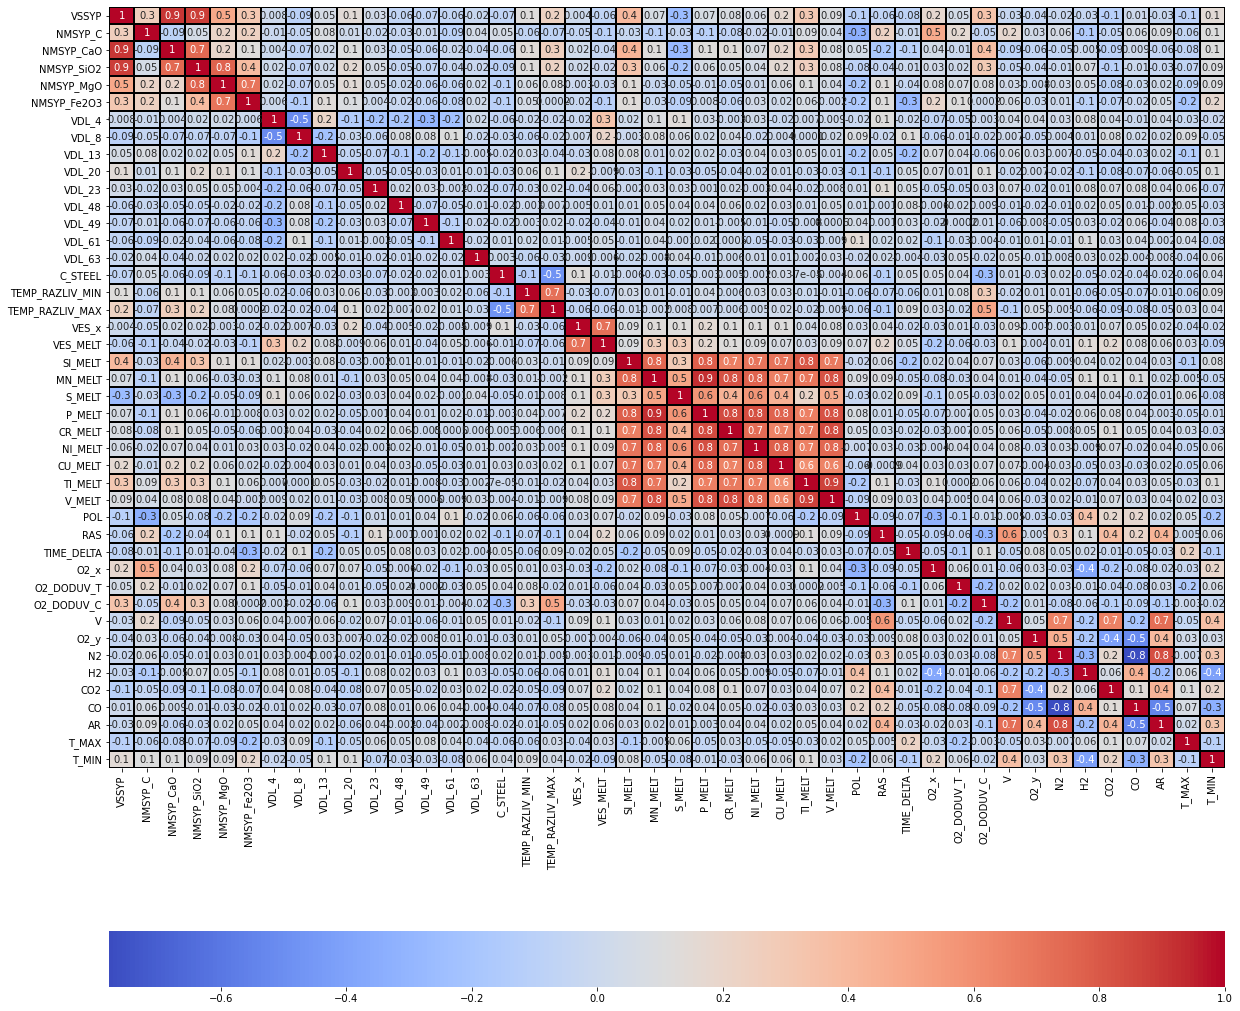

In [77]:
plt.figure(figsize=(20, 20))
sns.heatmap(features_carbon.corr(), annot = True, fmt='.1g', cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'}, 
           linewidths=1, linecolor='black');

#!g1.1
scaler = MinMaxScaler()
features_carbon_sc = scaler.fit_transform(features_carbon)

In [78]:
#!g1.1
cv = 5
rnd_st = 12345

In [79]:
#!g1.1
features_train_carbon, features_valid_carbon, target_train_carbon, target_valid_carbon = train_test_split(features_carbon, target_carbon, 
                                                                            test_size = 0.1, random_state = rnd_st)

In [80]:
features_carbon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 2134
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VSSYP            2127 non-null   int64  
 1   NMSYP_C          2127 non-null   float64
 2   NMSYP_CaO        2127 non-null   float64
 3   NMSYP_SiO2       2127 non-null   float64
 4   NMSYP_MgO        2127 non-null   float64
 5   NMSYP_Fe2O3      2127 non-null   float64
 6   VDL_4            2127 non-null   int64  
 7   VDL_8            2127 non-null   int64  
 8   VDL_13           2127 non-null   int64  
 9   VDL_20           2127 non-null   int64  
 10  VDL_23           2127 non-null   int64  
 11  VDL_48           2127 non-null   int64  
 12  VDL_49           2127 non-null   int64  
 13  VDL_61           2127 non-null   int64  
 14  VDL_63           2127 non-null   int64  
 15  C_STEEL          2127 non-null   float64
 16  TEMP_RAZLIV_MIN  2127 non-null   float64
 17  TEMP_RAZLIV_MA

In [81]:
#!g1.1
model_params_carbon = {
    #'RandomForestRegressor' : {
        #'model': RandomForestRegressor(),
        #'params': {
            #'n_estimators': range (1, 100, 10),
            #'max_depth': range (1, 4)
            #},
    #},
    'XGBoost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': range (1, 51, 2),
            'max_depth': range (1, 10)
        }
    #},
    #'LGBMRegressor': {
        #'model': LGBMRegressor(),
        #'params': {
            #'n_estimators': range (1, 100, 10),
            #'max_depth': range (1, 4),
        #}
    #},
    #'CatBoostRegressor':{
        #'model': CatBoostRegressor(),
        #'params': {
            #'loss_function':['MAE'],
            #'n_estimators': range (1, 100, 10),  
            #'learning_rate': [0.01],
            #'depth': range (1, 4)
            #}
        }  
    }

In [82]:
scores_carbon = []

for model_name, mpc in model_params_carbon.items():
    start_learning = time.monotonic()
    grid_carbon = GridSearchCV(mpc['model'], mpc['params'], scoring='neg_mean_absolute_error', 
                              cv = cv, verbose = 3, n_jobs = -1)
    grid_carbon.fit(features_train_carbon, target_train_carbon)
    end_learning = time.monotonic()
    learning_time = end_learning - start_learning
    
    scores_carbon.append({
        'model': model_name,
        'best_score': (-1)*grid_carbon.best_score_,
        'best_params': grid_carbon.best_params_,
        'learning_time': learning_time,
        'time_learning_1': grid_carbon.refit_time_,
    })

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.2min finished


In [83]:
#!g1.1
model_score_carbon = pd.DataFrame(scores_carbon,columns=['model','best_score','best_params', 'learning_time', 
                                           'time_learning_1'])
model_score_carbon

,model,best_score,best_params,learning_time,time_learning_1
0,XGBoost,0.025013,"{'max_depth': 3, 'n_estimators': 45}",69.672,0.089992


In [84]:
#!g1.1
model_carbon = xgboost.XGBRegressor(n_estimators = 33, max_depth = 3, eval_metric ='mae', random_state = rnd_st, verbose = 100) 
model_carbon.fit(features_train_carbon, target_train_carbon)
predicted_carbon = grid_carbon.predict(features_valid_carbon)
MAE = mean_absolute_error(target_valid_carbon, predicted_carbon)
print("Средняя абсолютная ошибка, MAE:", '{:.7f}'.format(MAE))

[08:28:25] WARNING: ..\src\learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Средняя абсолютная ошибка, MAE: 0.0221761


In [85]:
delta_c = np.abs(np.array(predicted_carbon) - np.array(target_valid_carbon))
hit_rate_c = np.int64(delta_c < 0.02)
N = np.size(predicted_carbon)
np.sum(hit_rate_c)/N

0.7370892018779343

#!g1.1
Посмотрим какие параметры наиболее сильно влияют на модель

explainer = shap.Explainer(model_carbon)
shap_values = explainer(features_train_carbon)
shap.plots.waterfall(shap_values[0])

shap.plots.force(shap_values[0])

shap.plots.beeswarm(shap_values)

#!g1.1
df_feature_importance = pd.DataFrame(model_carbon.feature_importances_, index=features_carbon.columns,
                                     columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind = 'bar', figsize = (15, 5));

## Построим модель для прогнозирования температуры

In [87]:
#!g1.1
features_temp = model_data.drop(['C','TST', 'plavka_TIPE_GOL_2','plavka_TIPE_GOL_3','plavka_TIPE_GOL_1','VDL_3'], axis = 1)
target_temp = model_data['TST']
features_temp

,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63,C_STEEL,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX,VES_x,VES_MELT,SI_MELT,MN_MELT,S_MELT,P_MELT,CR_MELT,NI_MELT,CU_MELT,TI_MELT,V_MELT,POL,RAS,TIME_DELTA,O2_x,O2_DODUV_T,O2_DODUV_C,V,O2_y,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,20970,2566.5,12986.6,508.20,3025.20,137.6,56500,16700,3000,0,0,0,0,0,0,0.170,1590.0,1660.0,263700.0,339900.0,1350.78,961.14,91.131,282.459,79.11,26.37,79.11,221.508,271.611,0.851547,9.746384e+05,202.0,2909.0,0.0,0.0,2.503499e+08,732.791599,49873.260023,763.260000,23253.560002,40936.864956,737.270001,131.597214,910.069458
1,23780,2549.1,17682.6,434.14,1429.44,76.8,49800,22800,6000,0,0,0,0,0,0,0.170,1590.0,1660.0,264500.0,343100.0,1995.10,922.00,76.405,257.625,52.90,26.45,79.35,253.920,222.180,0.807292,1.021916e+06,186.0,2182.0,0.0,0.0,2.624796e+08,413.789996,52142.309982,635.805000,24356.770027,43803.690006,759.334998,110.069443,893.750000
2,24070,2601.3,15333.1,560.61,3158.16,143.2,45900,22400,2000,0,6000,0,0,0,0,0.220,1585.0,1640.0,263800.0,340100.0,1668.03,1067.38,75.366,279.953,79.14,26.38,79.14,290.180,303.370,0.783986,1.005546e+06,208.0,2841.0,0.0,0.0,2.586918e+08,304.799999,52724.669945,860.795001,25111.109987,41601.874954,805.267499,125.347221,914.930542
3,27300,3149.4,20398.6,496.95,1574.20,78.4,51900,29200,3000,0,0,0,0,0,0,0.100,1585.0,1640.0,264000.0,348100.0,1477.45,1133.30,81.160,269.675,79.20,26.40,52.80,290.400,295.680,0.966364,8.522880e+05,174.0,10.0,0.0,0.0,2.276108e+08,864.031498,44680.098693,300.569109,21105.711587,37379.490505,648.594900,109.722221,842.708313
4,28540,2549.1,19022.5,640.05,3296.20,140.2,64000,6100,6000,0,0,0,0,0,0,0.045,1590.0,1710.0,263300.0,339400.0,1427.76,986.09,77.834,279.403,52.66,26.33,78.99,184.310,218.539,0.800000,1.007318e+06,183.0,2131.0,1094.0,0.0,2.632983e+08,601.326056,53649.139990,1252.009997,25662.279990,40383.129995,769.254997,130.902786,876.388916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,17530,0.0,13320.5,466.20,2319.60,57.8,51700,3300,3000,0,11500,4100,0,0,0,0.057,1590.0,1710.0,267200.0,340800.0,1199.36,1116.16,80.208,290.288,53.44,26.72,53.44,160.320,216.432,0.900000,9.065120e+05,990.0,0.0,1917.0,0.0,2.125513e+08,311.719996,31957.329971,2583.720003,21991.420010,48022.500028,537.864998,131.597214,815.972229
2131,22990,835.2,17430.0,553.40,2460.40,56.4,46400,15300,5000,0,9900,0,0,0,0,0.057,1590.0,1710.0,266800.0,343400.0,1525.50,1183.40,75.996,304.282,53.36,26.68,53.36,216.108,210.772,0.920000,9.437340e+05,942.0,0.0,0.0,1660.0,2.188806e+08,479.089998,33816.770043,2376.145002,21159.099994,51111.550049,558.209999,80.555550,826.388855
2132,23630,1200.6,17619.5,558.20,2474.80,56.6,41400,0,5000,0,0,17800,0,0,0,0.440,1590.0,1660.0,276100.0,340300.0,1844.71,1176.91,94.705,339.985,82.83,27.61,82.83,182.226,237.446,0.960000,8.833000e+05,3737.0,0.0,0.0,0.0,2.066812e+08,450.390000,32333.430034,2641.715000,19912.050018,48911.255021,551.680001,114.236115,838.888916
2133,18930,452.4,14605.5,460.60,2030.00,46.2,59000,4200,3000,0,0,0,0,0,0,0.440,1590.0,1660.0,275800.0,342000.0,1213.54,1075.66,84.398,298.970,55.16,27.58,82.74,165.480,209.608,1.100000,9.448760e+05,2709.0,0.0,0.0,371.0,2.279062e+08,343.990004,40536.300028,2427.170002,24662.249973,47282.899972,649.754999,100.347221,783.333374


#!g1.1
scaler = MinMaxScaler()
features_temp_sc = scaler.fit_transform(features_temp)

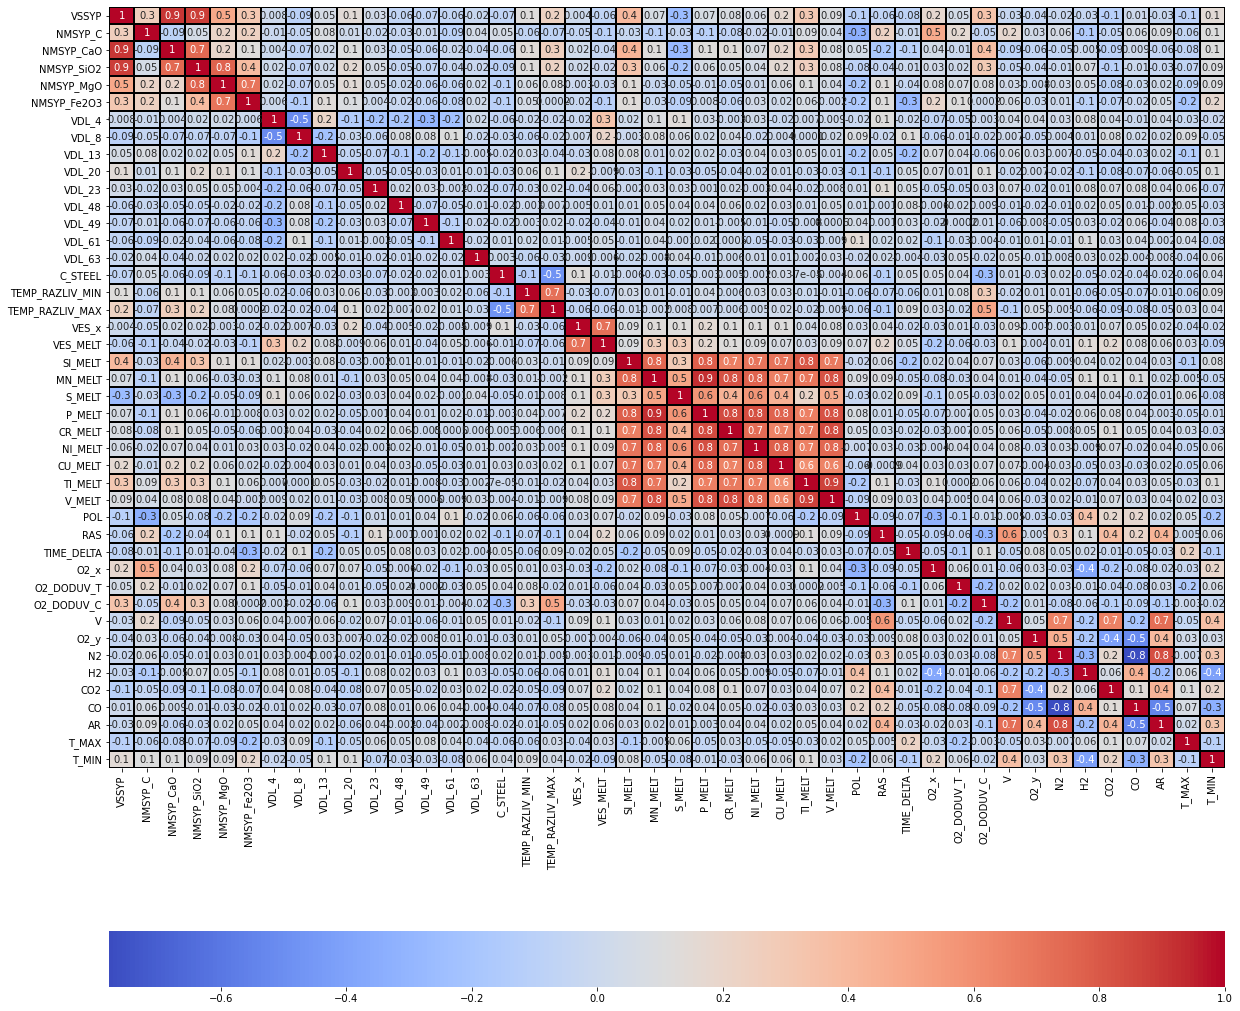

In [88]:
plt.figure(figsize=(20, 20))
sns.heatmap(features_temp.corr(), annot = True, fmt='.1g', cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'}, 
           linewidths=1, linecolor='black');

In [89]:
#!g1.1
features_train_temp, features_valid_temp, target_train_temp, target_valid_temp = train_test_split(features_temp, target_temp, 
                                                                            test_size = 0.1, random_state = rnd_st)

In [90]:
#!g1.1
model_params_temp = {
    #'RandomForestRegressor' : {
        #'model': RandomForestRegressor(),
        #'params': {
            #'n_estimators': range (1, 100, 10),
            #'max_depth': range (1, 4)
            #},
    #},
    'XGBoost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': range (1, 51, 2),
            'max_depth': range (1, 10),
        },
    #},
    #'LGBMRegressor': {
        #'model': LGBMRegressor(),
        #'params': {
            #'n_estimators': range (1, 100, 10),
            #'max_depth': range (1, 4),
        #}
    #},
    #'CatBoostRegressor':{
        #'model': CatBoostRegressor(),
        #'params': {
          #'loss_function':['MAE'],
          #'n_estimators': range (1, 100, 10),  
          #'learning_rate': [0.1],
          #'depth': range (1, 10)
        #}
    }
}

In [91]:
#!g1.1
scores_temp = []

for model_name, mpt in model_params_temp.items():
    start_learning = time.monotonic()
    grid_temp = GridSearchCV(mpt['model'], mpt['params'], scoring='neg_mean_absolute_error', 
                              cv = cv, verbose = 1, n_jobs = -1)
    grid_temp.fit(features_train_temp, target_train_temp)
    end_learning = time.monotonic()
    learning_time = end_learning - start_learning
    
    scores_temp.append({
        'model': model_name,
        'best_score': (-1)*grid_temp.best_score_,
        'best_params': grid_temp.best_params_,
        'learning_time': learning_time,
        'time_learning_1': grid_temp.refit_time_,
    })

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1118 out of 1125 | elapsed:   57.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:   58.1s finished


In [92]:
#!g1.1
model_score_temp = pd.DataFrame(scores_temp,columns=['model','best_score','best_params', 'learning_time', 
                                           'time_learning_1'])
model_score_temp

,model,best_score,best_params,learning_time,time_learning_1
0,XGBoost,14.861216,"{'max_depth': 3, 'n_estimators': 47}",58.297,0.080996


In [93]:
#!g1.1
model_temp = xgboost.XGBRegressor(n_estimators = 49, max_depth = 2, random_state = rnd_st) 
model_temp.fit(features_train_temp, target_train_temp)
predicted_temp = model_temp.predict(features_valid_temp)
MAE = mean_absolute_error(target_valid_temp, predicted_temp)
print("Средняя абсолютная ошибка, MAE:", '{:.7f}'.format(MAE))

Средняя абсолютная ошибка, MAE: 12.9636494


In [94]:
delta_t = np.abs(np.array(predicted_temp) - np.array(target_valid_temp))
hit_rate_t = np.int64(delta_t < 20)
N = np.size(predicted_temp)
np.sum(hit_rate_t)/N

0.8169014084507042

In [95]:
np.sum(hit_rate_c + hit_rate_t) / 2 / N

0.7769953051643192

Посмотрим какие параметры наиболее сильно влияют на модель

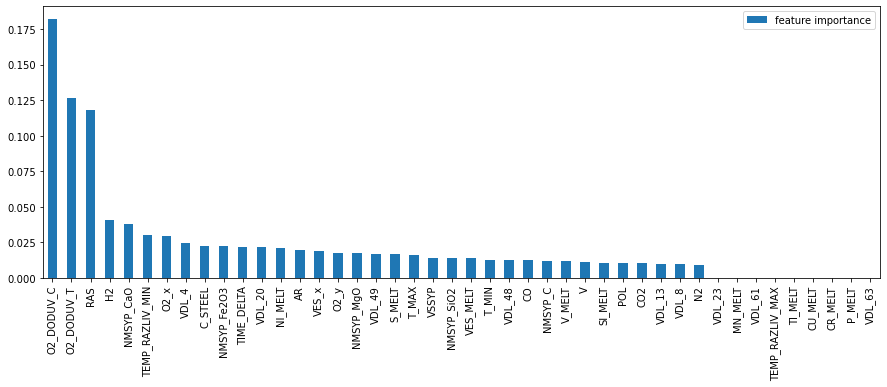

In [96]:
#!g1.1
df_feature_importance = pd.DataFrame(model_temp.feature_importances_, index=features_temp.columns,
                                     columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind = 'bar', figsize = (15, 5));

# Предобработка тестовых данных

In [97]:
test_data_produv = pd.read_csv('datasets_test/produv_test.csv')
test_data_lom = pd.read_csv('datasets_test/lom_test.csv')
test_data_plavki = pd.read_csv('datasets_test/plavki_test.csv')
test_data_sip = pd.read_csv('datasets_test/sip_test.csv')
test_data_chronom = pd.read_csv('datasets_test/chronom_test.csv')
test_data_chugun = pd.read_csv('datasets_test/chugun_test.csv')
test_data_gas = pd.read_csv('datasets_test/gas_test.csv')

### 1. Датасет produv (Параметры продувки)

In [98]:
test_data_furm =  test_data_produv.query("POL < 2") #11
test_model_produv_furm = test_data_furm.groupby('NPLV').agg(lambda x: x.median()).reset_index() #14
test_model_produv_V02 = test_data_produv.merge((test_data_chronom[['NPLV', 'VR_NACH','VR_KON','NOP']].query('NOP == "Продувка"')), how = 'left', on = 'NPLV')
test_model_produv_V02 = test_model_produv_V02.query('SEC > VR_NACH and SEC < VR_KON')
test_model_produv_V02.drop(['SEC', 'VR_NACH', 'VR_KON', 'NOP', 'POL'], axis = 1, inplace = True)
test_model_produv_V02 = test_model_produv_V02.groupby('NPLV').agg(lambda x: 2*x.sum()).reset_index()
test_model_produv_furm.drop(['RAS'], axis = 1, inplace = True)
test_model_produv = test_model_produv_furm.merge(test_model_produv_V02, how = 'left', on = 'NPLV') #18

### 2. Датасет lom (Параметры лома)

In [99]:
test_data_lom_ohe = test_data_lom
test_col_ohe = pd.get_dummies(test_data_lom['VDL'], prefix = 'VDL') #23
test_data_lom_ohe = pd.concat((test_data_lom_ohe, test_col_ohe), axis=1).drop(['VDL'], axis=1)


test_vdl_list = test_data_lom_ohe.columns.tolist()[3:]
for col in test_vdl_list:
    test_data_lom_ohe[col] = test_data_lom_ohe[col]*test_data_lom_ohe['VES']
test_data_lom_ohe.drop(['NML', 'VES'], axis=1, inplace = True)
test_data_lom_ohe = test_data_lom_ohe.groupby('NPLV').agg(lambda x: x.sum()).reset_index() #25
test_data_lom_ohe

,NPLV,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63
0,512324,26040,17660,2000,0,0,0,0,0,0
1,512327,49400,10600,3000,0,8000,0,0,0,0
2,512328,65700,0,6000,0,0,0,0,0,0
3,512331,36000,32500,2000,0,0,0,0,0,0
4,512333,40300,62200,2000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
775,513369,52700,2300,6000,0,0,0,0,0,0
776,513370,52700,0,3000,0,0,6600,0,0,0
777,513371,60100,0,6000,0,2000,0,0,0,0
778,513372,59600,3100,3000,0,0,500,0,0,0


### 3. Датасет plavki (Основная информация по плавке)

In [100]:
test_model_plav = test_data_plavki.drop(['plavka_VR_NACH', 'plavka_VR_KON', 'plavka_TIPE_FUR', 'plavka_STFUT', 'plavka_ST_FURM', 
                                'plavka_ST_GOL'], axis=1)
c_steel = pd.DataFrame(test_model_plav['plavka_NMZ'].unique().tolist(), columns = ['plavka_NMZ'])
test_c_steel = c_steel.merge(steel_mark, how = 'left', on = 'plavka_NMZ')
test_model_plav = test_model_plav.merge(test_c_steel, how = 'left', on = 'plavka_NMZ')
test_model_plav.drop(['ISTOCHNIK','plavka_NMZ'], axis=1, inplace = True)
test_model_plav_ohe = test_model_plav
test_col_ohe = pd.get_dummies(test_model_plav['plavka_TIPE_GOL'], prefix = 'plavka_TIPE_GOL')
test_model_plav_ohe = pd.concat((test_model_plav_ohe, test_col_ohe), axis=1).drop(['plavka_TIPE_GOL'], axis=1)
test_model_plav_ohe['plavka_TIPE_GOL_1'] = test_model_plav_ohe['plavka_TIPE_GOL_4-сопл x54          '] 
+ test_model_plav_ohe['plavka_TIPE_GOL_4-сопл х54          ']
test_model_plav_ohe.drop(['plavka_TIPE_GOL_4-сопл x54          ', 'plavka_TIPE_GOL_4-сопл х54          '],axis = 1, 
                    inplace = True)
test_model_plav_ohe.rename(columns={"plavka_TIPE_GOL_5 сопловая          ": "plavka_TIPE_GOL_2",
                              "plavka_TIPE_GOL_Э, 4-сопл х54       ": "plavka_TIPE_GOL_3"}, inplace = True)
for i in range(len(test_model_plav_ohe)):
    if test_model_plav_ohe.loc[i, 'plavka_NAPR_ZAD'] == "МНЛС": # сортовая МНЛЗ с АКП
        test_model_plav_ohe.loc[i, 'TEMP_RAZLIV_MIN'] = 1590,
        test_model_plav_ohe.loc[i, 'TEMP_RAZLIV_MAX'] = 1710
    if test_model_plav_ohe.loc[i, 'plavka_NAPR_ZAD'] == "МНЛЗ": 
        test_model_plav_ohe.loc[i, 'TEMP_RAZLIV_MIN'] = 1590,
        test_model_plav_ohe.loc[i, 'TEMP_RAZLIV_MAX'] = 1660 
    if test_model_plav_ohe.loc[i, 'plavka_NAPR_ZAD'] == "Изл":
        test_model_plav_ohe.loc[i, 'TEMP_RAZLIV_MIN'] = 1585,
        test_model_plav_ohe.loc[i, 'TEMP_RAZLIV_MAX'] = 1640
test_model_plavki = test_model_plav_ohe.drop(['plavka_NAPR_ZAD'], axis = 1)
test_model_plavki

,NPLV,C_STEEL,plavka_TIPE_GOL_2,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_Э32,"plavka_TIPE_GOL_Э37, 4-сопл х54",plavka_TIPE_GOL_1,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX
0,512324,0.22,0,0,0,0,0,1585.0,1640.0
1,512327,NaN,0,0,0,0,0,1590.0,1710.0
2,512328,0.22,0,0,0,0,0,1585.0,1640.0
3,512331,0.29,0,0,0,0,0,1585.0,1640.0
4,512333,0.09,0,0,0,0,0,1590.0,1710.0
...,...,...,...,...,...,...,...,...,...
775,513369,NaN,0,1,0,0,0,1590.0,1660.0
776,513370,NaN,0,1,0,0,0,1590.0,1660.0
777,513371,NaN,0,1,0,0,0,1590.0,1660.0
778,513372,NaN,0,1,0,0,0,1590.0,1660.0


### 4. Датасет sip (Сыпучие добавки)

In [101]:
test_data_sip_ohe = test_data_sip
test_col_ohe = pd.get_dummies(test_data_sip['NMSYP'], prefix = 'NMSYP')
test_data_sip_ohe = pd.concat((test_data_sip_ohe, col_ohe), axis=1).drop(['NMSYP'], axis=1)

test_vdsyp_list = test_data_sip_ohe.columns.tolist()[4:]
for col in test_vdsyp_list:
    test_data_sip_ohe[col] = test_data_sip_ohe[col]*test_data_sip_ohe['VSSYP']
test_data_sip_ohe.drop(['VDSYP', 'VSSYP', 'DAT_OTD'], axis=1, inplace = True)
test_data_table = pd.read_csv("my_data/flus.csv")
test_data_table.drop(['ISTOCHNIK_2'], axis = 1, inplace = True)
test_data_sip_ohe = test_data_sip_ohe.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
test_model_sip = test_data_sip.merge(test_data_table, how = 'left', on = 'NMSYP')
test_data_sip_ohe = test_model_sip.drop(['VDSYP', 'NMSYP', 'DAT_OTD'], axis = 1)
test_data_sip_ohe
test_nmsyp_list = test_data_sip_ohe.columns.tolist()[2:]
for col in test_nmsyp_list:
    test_data_sip_ohe[col] = (test_data_sip_ohe[col]*test_data_sip_ohe['VSSYP'])/100
test_data_sip_ohe = test_data_sip_ohe.groupby('NPLV').agg(lambda x: x.sum()).reset_index()

### 5. Датасет chronom (Хронометраж)

In [102]:
test_model_chronom = test_data_chronom.query('NOP == "Нагрев лома"')
test_model_chronom = test_model_chronom.drop(['Unnamed: 0'], axis=1)
test_model_chronom['VR_KON'] = pd.to_datetime(test_model_chronom['VR_KON'])
test_model_chronom['VR_NACH'] = pd.to_datetime(test_model_chronom['VR_NACH'])
test_model_chronom['PRODUV_DLIT'] = (test_model_chronom['VR_KON'] - test_model_chronom['VR_NACH']).dt.total_seconds()
test_model_chronom.fillna(0)
test_model_chronom = test_data_chronom.query('NOP == "Нагрев лома"')
test_model_chronom = test_model_chronom.drop(['Unnamed: 0'], axis=1)

test_model_chronom[['VR_NACH','VR_KON']]= pd.to_datetime(test_model_chronom[['VR_NACH','VR_KON']].stack(), errors='coerce').unstack()
test_model_chronom['PRODUV_DLIT'] = (test_model_chronom['VR_KON'] - test_model_chronom['VR_NACH']).dt.total_seconds()
test_model_chronom.reset_index(drop=True, inplace=True)
test_model_chronom_02_SUM = test_model_chronom[['NPLV','O2']].groupby('NPLV').agg(lambda x: x.sum()).reset_index()

test_model_time_start_produv = test_data_chronom.query('NOP == "Продувка"')
test_model_time_chugun = test_data_chugun[['NPLV','DATA_ZAMERA']]
test_model_time_delta = test_model_time_start_produv.merge(test_model_time_chugun, how = 'left', on = 'NPLV')
test_model_time_delta.drop(['Unnamed: 0','TYPE_OPER','NOP','O2'], axis = 1,inplace = True)
test_model_time_delta['VR_NACH'] = pd.to_datetime(test_model_time_delta['VR_NACH'])
test_model_time_delta['DATA_ZAMERA'] = pd.to_datetime(test_model_time_delta['DATA_ZAMERA'])
test_model_time_delta['TIME_DELTA'] = (test_model_time_delta['VR_NACH'] - test_model_time_delta['DATA_ZAMERA']).dt.total_seconds()

test_model_chronom_DODUV_T = test_data_chronom.query('NOP == "Додувка на t"')
test_model_chronom_DODUV_T = test_model_chronom_DODUV_T[['NPLV','O2']]
test_model_chronom_DODUV_T = test_model_chronom_DODUV_T.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
test_model_chronom_DODUV_T.rename(columns={"O2": "O2_DODUV_T"},inplace=True)
test_model_chronom_DODUV_T

test_model_chronom_DODUV_C = test_data_chronom.query('NOP == "Додувка на C"')
test_model_chronom_DODUV_C = test_model_chronom_DODUV_C[['NPLV','O2']]
test_model_chronom_DODUV_C = test_model_chronom_DODUV_C.groupby('NPLV').agg(lambda x: x.sum()).reset_index()
test_model_chronom_DODUV_C.rename(columns={"O2": "O2_DODUV_C"},inplace=True)

test_model_chronom = test_model_time_delta.merge(test_model_chronom_02_SUM, how = 'left', on = 'NPLV') \
                .merge(test_model_chronom_DODUV_T, how = 'left', on = 'NPLV') \
                .merge(test_model_chronom_DODUV_C, how = 'left', on = 'NPLV')
test_model_chronom.drop(['VR_NACH','VR_KON','DATA_ZAMERA'], axis = 1, inplace = True)
test_model_chronom = test_model_chronom.fillna(0)

### 6. Датасет chugun (Химический состав и характеристики чугуна)

In [103]:
test_data_lom_sum_plav = test_data_lom[['NPLV', 'VES']].groupby('NPLV').agg(lambda x: x.sum()).reset_index()

test_data_shichta = test_data_chugun.merge(test_data_lom_sum_plav, how = 'left', on = 'NPLV')

test_data_shichta['SI_MELT'] = test_data_shichta['SI']*test_data_shichta['VES_x']/100 + 0.25*test_data_shichta['VES_y']/100
test_data_shichta['MN_MELT'] = test_data_shichta['MN']*test_data_shichta['VES_x']/100 + 0.5*test_data_shichta['VES_y']/100
test_data_shichta['S_MELT'] = test_data_shichta['S']*test_data_shichta['VES_x']/100 + 0.04*test_data_shichta['VES_y']/100
test_data_shichta['P_MELT'] = test_data_shichta['P']*test_data_shichta['VES_x']/100 + 0.035*test_data_shichta['VES_y']/100
test_data_shichta['CR_MELT'] = test_data_shichta['CR']*test_data_shichta['VES_x']/100
test_data_shichta['NI_MELT'] = test_data_shichta['NI']*test_data_shichta['VES_x']/100
test_data_shichta['CU_MELT'] = test_data_shichta['CU']*test_data_shichta['VES_x']/100
test_data_shichta['TI_MELT'] = test_data_shichta['TI']*test_data_shichta['VES_x']/100
test_data_shichta['V_MELT'] = test_data_shichta['V']*test_data_shichta['VES_x']/100
test_data_shichta['VES_MELT'] = test_data_shichta['VES_x'] + test_data_shichta['VES_y']
test_model_shichta = test_data_shichta[['NPLV','VES_x','VES_MELT','SI_MELT','MN_MELT', 'S_MELT', 'P_MELT', 'CR_MELT','NI_MELT','CU_MELT',
                             'TI_MELT', 'V_MELT']]

### 7. Датасет gas (Информация об анализе отходящих газов)

In [104]:
test_data_gas.drop(['O2_pressure'], axis = 1, inplace = True)

test_data_gas['T_MAX'] = test_data_gas.groupby('NPLV')['T'].transform('min')
test_data_gas['T_MIN'] = test_data_gas.groupby('NPLV')['T'].transform('max')
test_data_gas2 = test_data_gas.merge((test_data_chronom[['NPLV', 'VR_NACH','VR_KON','NOP']].query('NOP == "Продувка"')), how = 'left', on = 'NPLV')
test_data_gas2['Time'] = pd.to_datetime(test_data_gas2['Time'])
test_data_gas2['VR_NACH'] = pd.to_datetime(test_data_gas2['VR_NACH'])
test_data_gas2['VR_KON'] = pd.to_datetime(test_data_gas2['VR_KON'])
test_data_gas2 = test_data_gas2.query("Time > VR_NACH and Time < VR_KON")
test_data_gas_SUM = test_data_gas2[['NPLV','V', 'O2', 'N2', 'H2','CO2','CO','AR']].groupby('NPLV').agg(lambda x: x.sum()).reset_index()
test_data_gas_T = test_data_gas2[['NPLV', 'T_MAX', 'T_MIN']].drop_duplicates()
test_model_gas = test_data_gas_SUM.merge(test_data_gas_T, how = 'left', on = 'NPLV', right_index=False)
test_model_gas.drop_duplicates().reset_index()

,index,NPLV,V,O2,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,0,512324,2.540041e+08,797.388914,62844.525120,426.050000,28129.416847,32223.376275,895.375000,65.972221,831.250000
1,1,512327,2.417829e+08,675.399997,42168.479988,302.788604,22760.309945,40120.070083,672.990000,105.902779,825.347229
2,2,512328,2.469726e+08,898.039991,44680.389997,525.185001,22950.840012,42057.009962,705.114999,93.750000,938.888855
3,3,512331,2.379559e+08,844.049988,42110.230015,506.020000,22075.859983,43505.310022,641.864997,104.166664,794.097229
4,4,512333,2.293896e+08,661.957606,40530.120047,401.397960,21660.419982,44724.150049,604.769998,99.652779,811.111084
...,...,...,...,...,...,...,...,...,...,...,...
775,775,513369,2.621588e+08,439.408823,45922.010000,1582.369999,28630.229994,42821.542333,822.460000,109.375000,825.347229
776,776,513370,2.504154e+08,519.420000,41787.169988,1440.575072,27682.750000,42979.593931,784.079999,152.777786,857.291626
777,777,513371,2.542929e+08,667.428878,44966.469948,1188.068845,28863.750022,40319.455112,847.135001,123.263893,877.430542
778,778,513372,2.856568e+08,1092.841730,61468.179892,1690.054997,33537.719984,33948.969998,1038.151134,125.694450,892.361145


### 8. join

In [105]:
test_df = test_data_sip_ohe.merge(test_data_lom_ohe, how = 'left', on = 'NPLV') \
    .merge(test_model_plavki, how = 'left', on = 'NPLV') \
    .merge(test_model_shichta, how = 'left', on = 'NPLV') \
    .merge(test_model_produv, how = 'left', on = 'NPLV') \
    .merge(test_model_chronom, how = 'left', on = 'NPLV') \
    .merge(test_model_gas, how = 'left', on = 'NPLV')
test_df.columns

Index(['NPLV', 'VSSYP', 'NMSYP_C', 'NMSYP_CaO', 'NMSYP_SiO2', 'NMSYP_MgO',
       'NMSYP_Fe2O3', 'VDL_4', 'VDL_8', 'VDL_13', 'VDL_20', 'VDL_23', 'VDL_48',
       'VDL_49', 'VDL_61', 'VDL_63', 'C_STEEL', 'plavka_TIPE_GOL_2',
       'plavka_TIPE_GOL_601-5               ',
       'plavka_TIPE_GOL_Э32                 ',
       'plavka_TIPE_GOL_Э37, 4-сопл х54     ', 'plavka_TIPE_GOL_1',
       'TEMP_RAZLIV_MIN', 'TEMP_RAZLIV_MAX', 'VES_x', 'VES_MELT', 'SI_MELT',
       'MN_MELT', 'S_MELT', 'P_MELT', 'CR_MELT', 'NI_MELT', 'CU_MELT',
       'TI_MELT', 'V_MELT', 'POL', 'RAS', 'TIME_DELTA', 'O2_x', 'O2_DODUV_T',
       'O2_DODUV_C', 'V', 'O2_y', 'N2', 'H2', 'CO2', 'CO', 'AR', 'T_MAX',
       'T_MIN'],
      dtype='object')

# Предсказания на тестовой выборке

In [106]:
test_data = test_df.drop(['NPLV','plavka_TIPE_GOL_2','plavka_TIPE_GOL_601-5               ','plavka_TIPE_GOL_Э32                 ',
                            'plavka_TIPE_GOL_Э37, 4-сопл х54     ','plavka_TIPE_GOL_1'], axis = 1)
test_data

,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63,C_STEEL,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX,VES_x,VES_MELT,SI_MELT,MN_MELT,S_MELT,P_MELT,CR_MELT,NI_MELT,CU_MELT,TI_MELT,V_MELT,POL,RAS,TIME_DELTA,O2_x,O2_DODUV_T,O2_DODUV_C,V,O2_y,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,16940,1139.7,12647.5,379.4,1560.4,33.4,26040,17660,2000,0,0,0,0,0,0,0.22,1585.0,1640.0,240100.0,285800.0,1218.71,1020.83,83.107,205.674,24.01,24.01,48.02,72.030,115.248,0.97,880338.0,2425.0,1452.0,0.0,0.0,2.540041e+08,797.388914,62844.525120,426.050000,28129.416847,32223.376275,895.375000,65.972221,831.250000
1,15340,0.0,13761.0,305.8,611.6,0.0,49400,10600,3000,0,8000,0,0,0,0,NaN,1590.0,1710.0,266400.0,337400.0,976.70,1234.12,113.648,288.586,26.64,0.00,0.00,63.936,133.200,1.00,913518.0,4683.0,0.0,0.0,0.0,2.417829e+08,675.399997,42168.479988,302.788604,22760.309945,40120.070083,672.990000,105.902779,825.347229
2,21410,0.0,18009.0,400.2,800.4,0.0,65700,0,6000,0,0,0,0,0,0,0.22,1585.0,1640.0,270200.0,341900.0,179.25,358.50,28.680,25.095,0.00,0.00,0.00,0.000,0.000,1.22,958730.0,677.0,0.0,0.0,0.0,2.469726e+08,898.039991,44680.389997,525.185001,22950.840012,42057.009962,705.114999,93.750000,938.888855
3,14990,0.0,12654.0,281.2,562.4,0.0,36000,32500,2000,0,0,0,0,0,0,0.29,1585.0,1640.0,266700.0,337200.0,1616.43,1392.63,102.876,331.380,53.34,26.67,80.01,112.014,157.353,1.03,953700.0,4651.0,0.0,0.0,0.0,2.379559e+08,844.049988,42110.230015,506.020000,22075.859983,43505.310022,641.864997,104.166664,794.097229
4,21060,0.0,18090.0,402.0,804.0,0.0,40300,62200,2000,0,0,0,0,0,0,0.09,1590.0,1710.0,267400.0,371900.0,261.25,522.50,41.800,36.575,0.00,0.00,0.00,0.000,0.000,1.02,927144.0,1372.0,0.0,0.0,0.0,2.293896e+08,661.957606,40530.120047,401.397960,21660.419982,44724.150049,604.769998,99.652779,811.111084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,18980,1748.7,12740.0,458.6,2347.6,59.6,52700,2300,6000,0,0,0,0,0,0,NaN,1590.0,1660.0,280800.0,341800.0,1135.30,1119.32,122.680,290.918,28.08,28.08,56.16,174.096,224.640,1.18,1014744.0,1980.0,2433.0,0.0,0.0,2.621588e+08,439.408823,45922.010000,1582.369999,28630.229994,42821.542333,822.460000,109.375000,825.347229
776,18970,1905.3,12764.5,445.6,2211.2,55.0,52700,0,3000,0,0,6600,0,0,0,NaN,1590.0,1660.0,280600.0,342900.0,1250.09,1181.36,92.264,293.987,28.06,28.06,56.12,207.644,260.958,1.17,965646.0,2563.0,2232.0,0.0,0.0,2.504154e+08,519.420000,41787.169988,1440.575072,27682.750000,42979.593931,784.079999,152.777786,857.291626
777,17330,1766.1,11288.0,422.8,2247.2,58.4,60100,0,6000,0,2000,0,0,0,0,NaN,1590.0,1660.0,279700.0,347800.0,1009.35,1095.69,113.947,300.738,27.97,27.97,55.94,100.692,184.602,1.06,980666.0,1675.0,1904.0,0.0,0.0,2.542929e+08,667.428878,44966.469948,1188.068845,28863.750022,40319.455112,847.135001,123.263893,877.430542
778,14930,0.0,10955.0,415.4,2232.4,58.4,59600,3100,3000,0,0,500,0,0,0,NaN,1590.0,1660.0,279700.0,345900.0,1368.21,1254.01,99.202,339.231,27.97,27.97,55.94,195.790,265.715,1.26,1033866.0,2468.0,0.0,0.0,0.0,2.856568e+08,1092.841730,61468.179892,1690.054997,33537.719984,33948.969998,1038.151134,125.694450,892.361145


In [107]:
#test_data = scaler.transform(test_data)

In [108]:
predicted_test_carbon = model_carbon.predict(test_data)
test_data['C_STEEL'] = pd.DataFrame(predicted_test_carbon.tolist())

In [109]:
test_data

,VSSYP,NMSYP_C,NMSYP_CaO,NMSYP_SiO2,NMSYP_MgO,NMSYP_Fe2O3,VDL_4,VDL_8,VDL_13,VDL_20,VDL_23,VDL_48,VDL_49,VDL_61,VDL_63,C_STEEL,TEMP_RAZLIV_MIN,TEMP_RAZLIV_MAX,VES_x,VES_MELT,SI_MELT,MN_MELT,S_MELT,P_MELT,CR_MELT,NI_MELT,CU_MELT,TI_MELT,V_MELT,POL,RAS,TIME_DELTA,O2_x,O2_DODUV_T,O2_DODUV_C,V,O2_y,N2,H2,CO2,CO,AR,T_MAX,T_MIN
0,16940,1139.7,12647.5,379.4,1560.4,33.4,26040,17660,2000,0,0,0,0,0,0,0.072899,1585.0,1640.0,240100.0,285800.0,1218.71,1020.83,83.107,205.674,24.01,24.01,48.02,72.030,115.248,0.97,880338.0,2425.0,1452.0,0.0,0.0,2.540041e+08,797.388914,62844.525120,426.050000,28129.416847,32223.376275,895.375000,65.972221,831.250000
1,15340,0.0,13761.0,305.8,611.6,0.0,49400,10600,3000,0,8000,0,0,0,0,0.068748,1590.0,1710.0,266400.0,337400.0,976.70,1234.12,113.648,288.586,26.64,0.00,0.00,63.936,133.200,1.00,913518.0,4683.0,0.0,0.0,0.0,2.417829e+08,675.399997,42168.479988,302.788604,22760.309945,40120.070083,672.990000,105.902779,825.347229
2,21410,0.0,18009.0,400.2,800.4,0.0,65700,0,6000,0,0,0,0,0,0,0.066627,1585.0,1640.0,270200.0,341900.0,179.25,358.50,28.680,25.095,0.00,0.00,0.00,0.000,0.000,1.22,958730.0,677.0,0.0,0.0,0.0,2.469726e+08,898.039991,44680.389997,525.185001,22950.840012,42057.009962,705.114999,93.750000,938.888855
3,14990,0.0,12654.0,281.2,562.4,0.0,36000,32500,2000,0,0,0,0,0,0,0.049907,1585.0,1640.0,266700.0,337200.0,1616.43,1392.63,102.876,331.380,53.34,26.67,80.01,112.014,157.353,1.03,953700.0,4651.0,0.0,0.0,0.0,2.379559e+08,844.049988,42110.230015,506.020000,22075.859983,43505.310022,641.864997,104.166664,794.097229
4,21060,0.0,18090.0,402.0,804.0,0.0,40300,62200,2000,0,0,0,0,0,0,0.057344,1590.0,1710.0,267400.0,371900.0,261.25,522.50,41.800,36.575,0.00,0.00,0.00,0.000,0.000,1.02,927144.0,1372.0,0.0,0.0,0.0,2.293896e+08,661.957606,40530.120047,401.397960,21660.419982,44724.150049,604.769998,99.652779,811.111084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,18980,1748.7,12740.0,458.6,2347.6,59.6,52700,2300,6000,0,0,0,0,0,0,0.049728,1590.0,1660.0,280800.0,341800.0,1135.30,1119.32,122.680,290.918,28.08,28.08,56.16,174.096,224.640,1.18,1014744.0,1980.0,2433.0,0.0,0.0,2.621588e+08,439.408823,45922.010000,1582.369999,28630.229994,42821.542333,822.460000,109.375000,825.347229
776,18970,1905.3,12764.5,445.6,2211.2,55.0,52700,0,3000,0,0,6600,0,0,0,0.058908,1590.0,1660.0,280600.0,342900.0,1250.09,1181.36,92.264,293.987,28.06,28.06,56.12,207.644,260.958,1.17,965646.0,2563.0,2232.0,0.0,0.0,2.504154e+08,519.420000,41787.169988,1440.575072,27682.750000,42979.593931,784.079999,152.777786,857.291626
777,17330,1766.1,11288.0,422.8,2247.2,58.4,60100,0,6000,0,2000,0,0,0,0,0.037301,1590.0,1660.0,279700.0,347800.0,1009.35,1095.69,113.947,300.738,27.97,27.97,55.94,100.692,184.602,1.06,980666.0,1675.0,1904.0,0.0,0.0,2.542929e+08,667.428878,44966.469948,1188.068845,28863.750022,40319.455112,847.135001,123.263893,877.430542
778,14930,0.0,10955.0,415.4,2232.4,58.4,59600,3100,3000,0,0,500,0,0,0,0.044452,1590.0,1660.0,279700.0,345900.0,1368.21,1254.01,99.202,339.231,27.97,27.97,55.94,195.790,265.715,1.26,1033866.0,2468.0,0.0,0.0,0.0,2.856568e+08,1092.841730,61468.179892,1690.054997,33537.719984,33948.969998,1038.151134,125.694450,892.361145


In [110]:
predicted_test_temp = model_temp.predict(test_data) 
features_test = predicted_test_temp.tolist()
answer = pd.DataFrame(predicted_test_carbon.tolist(), columns = ['C'])
answer['TST'] = features_test
answer['NPLV'] = test_df['NPLV']
answer = answer[['NPLV', 'TST', 'C']]
answer.to_csv('IT_metal.csv', index = False)

# 2 Оптимизационная задача

In [ ]:
Image("images/image_2.jpg", width=600)

Источник рис.1 раздела 2: Гичев Ю. А. Восстановительный потенциал отходящих газов сталеплавильных конвертеров / Ю. А. Гичев, О. В. Переверзева // Творческое наследие В. Е. Грум-Гржимайло: прошлое, современное состояние, будущее : сборник докладов международной научно-практической конференции (27-29 марта 2014 г., г. Екатеринбург). — Екатеринбург : УрФУ, 2014. — Ч. 1. — С. 140-147.

In [ ]:
Image("images/image_3.jpg", width=600)

Источник рис. 1.1 раздела 2: Сергеев Дмитрий Станиславович. Разработка технологии выплавки стали в кислородных конвертерах с применением природного комплексного магнезиального флюса-охладителя: диссертация кандидата Технических наук: 05.16.02 / Сергеев Дмитрий Станиславович;[Место защиты: ФГБОУ ВО Магнитогорский государственный технический университет им. Г.И. Носова], 2017г. (http://magtu.ru/servisy-sajta/fajlovyj-arkhiv/send/461-sergeev-dmitrij-stanislavovich/7049-dissertatsiya-sergeeva-d-s.html)